In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 13.9MB/s 
     |████████████████████████████████| 163kB 44.9MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 112kB 46.7MB/s 
     |████████████████████████████████| 143kB 46.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=9d03b732a7c9f0cd07621f594a4cf1701f9cce02a62afc66698ed02d3f9391b1
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("yamaoka/*/")
data = []
label = []
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['yamaoka_149.jpg', 'yamaoka_150.jpg', 'yamaoka_153.jpg', 'yamaoka_155.jpg', 'yamaoka_156.jpg', 'yamaoka_158.jpg', 'yamaoka_159.jpg', 'yamaoka_160.jpg', 'yamaoka_161.jpg', 'yamaoka_162.jpg', 'yamaoka_163.jpg', 'yamaoka_165.jpg', 'yamaoka_166.jpg', 'yamaoka_167.jpg', 'yamaoka_168.jpg', 'yamaoka_169.jpg', 'yamaoka_171.jpg', 'yamaoka_172.jpg', 'yamaoka_173.jpg', 'yamaoka_174.jpg', 'yamaoka_175.jpg', 'yamaoka_176.jpg', 'yamaoka_177.jpg', 'yamaoka_180.jpg', 'yamaoka_181.jpg', 'yamaoka_139.jpg', 'yamaoka_138.jpg', 'yamaoka_136.jpg', 'yamaoka_137.jpg', 'yamaoka_143.jpg', 'yamaoka_144.jpg', 'yamaoka_141.jpg', 'yamaoka_145.jpg', 'yamaoka_147.jpg', 'yamaoka_140.jpg', 'yamaoka_142.jpg', 'yamaoka_146.jpg', 'yamaoka_179.jpg', 'yamaoka_152.jpg', 'yamaoka_151.jpg', 'yamaoka_002.jpg', 'yamaoka_003.jpg', 'yamaoka_013.jpg', 'yamaoka_021.jpg', 'yamaoka_025.jpg', 'yamaoka_032.jpg', 'yamaoka_062.jpg', 'yamaoka_066.jpg', 'yamaoka_074.jpg', 'yamaoka_088.jpg', 'yamaoka_106.jpg', 'yamaoka_116.jpg', 'yamaoka_12

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 06:06:46,985] A new study created in memory with name: no-name-57896457-99b3-43eb-bbe0-c42b6245b3ca


18
Epoch 1/16
64/64 - 33s - loss: 0.5546 - accuracy: 0.8299 - val_loss: 0.4647 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4389 - accuracy: 0.8438 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3975 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3548 - accuracy: 0.8516 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3150 - accuracy: 0.8767 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2792 - accuracy: 0.8872 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2337 - accuracy: 0.9219 - val_loss: 0.4271 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2234 - accuracy: 0.9219 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2087 - accuracy: 0.9288 - val_loss: 0.4398 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1999 - accuracy: 0.9245 - val_loss: 0.4106 - val_accuracy: 0.8450
Epoch 11/16
64/

[I 2021-03-17 06:07:29,263] Trial 0 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4398599273179322}. Best is trial 0 with value: 0.10077518224716187.


Epoch 1/16
64/64 - 2s - loss: 0.8375 - accuracy: 0.4974 - val_loss: 0.6635 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6928 - accuracy: 0.6163 - val_loss: 0.6464 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6634 - accuracy: 0.7266 - val_loss: 0.6333 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6309 - accuracy: 0.8186 - val_loss: 0.6226 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6187 - accuracy: 0.8273 - val_loss: 0.6135 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6097 - accuracy: 0.8368 - val_loss: 0.6056 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6027 - accuracy: 0.8325 - val_loss: 0.5985 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5986 - accuracy: 0.8316 - val_loss: 0.5920 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5933 - accuracy: 0.8385 - val_loss: 0.5860 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5840 - accuracy: 0.8420 - val_loss: 0.5803 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:07:35,811] Trial 1 finished with value: 0.1627907156944275 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 32, 'optimizer': 'Adagrad', 'activation': 'softmax', 'dropout_rate': 0.4673665680841337}. Best is trial 0 with value: 0.10077518224716187.


Epoch 1/16
64/64 - 2s - loss: 0.9367 - accuracy: 0.5920 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6350 - accuracy: 0.7222 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5339 - accuracy: 0.7873 - val_loss: 0.4156 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4931 - accuracy: 0.8194 - val_loss: 0.4615 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4229 - accuracy: 0.8368 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4028 - accuracy: 0.8516 - val_loss: 0.4004 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3455 - accuracy: 0.8715 - val_loss: 0.3335 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3129 - accuracy: 0.8672 - val_loss: 0.4122 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2890 - accuracy: 0.8793 - val_loss: 0.3329 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2539 - accuracy: 0.9002 - val_loss: 0.2730 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:07:42,892] Trial 2 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.4414113423432039}. Best is trial 0 with value: 0.10077518224716187.


Epoch 1/16
64/64 - 1s - loss: 0.7865 - accuracy: 0.6562 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3975 - accuracy: 0.8316 - val_loss: 0.4110 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2915 - accuracy: 0.8906 - val_loss: 0.3735 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2434 - accuracy: 0.9080 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1759 - accuracy: 0.9375 - val_loss: 0.3261 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1562 - accuracy: 0.9497 - val_loss: 0.3128 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1211 - accuracy: 0.9653 - val_loss: 0.3474 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1325 - accuracy: 0.9523 - val_loss: 0.2503 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1053 - accuracy: 0.9609 - val_loss: 0.2533 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0787 - accuracy: 0.9722 - val_loss: 0.2221 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:07:46,308] Trial 3 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.3535210782384851}. Best is trial 3 with value: 0.09302324056625366.


Epoch 1/16
64/64 - 1s - loss: 0.9243 - accuracy: 0.5703 - val_loss: 0.4793 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6726 - accuracy: 0.6979 - val_loss: 0.4344 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5420 - accuracy: 0.7595 - val_loss: 0.4211 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4231 - accuracy: 0.8299 - val_loss: 0.4609 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3607 - accuracy: 0.8628 - val_loss: 0.4939 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8854 - val_loss: 0.3708 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.8880 - val_loss: 0.3270 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2122 - accuracy: 0.9184 - val_loss: 0.2832 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2089 - accuracy: 0.9306 - val_loss: 0.3197 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1535 - accuracy: 0.9444 - val_loss: 0.1796 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 06:07:51,544] Trial 4 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 96, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.37692692499829566}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 2s - loss: 0.9949 - accuracy: 0.5495 - val_loss: 0.4936 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6948 - accuracy: 0.6745 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5821 - accuracy: 0.7500 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5457 - accuracy: 0.7882 - val_loss: 0.4239 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4563 - accuracy: 0.8212 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4608 - accuracy: 0.8108 - val_loss: 0.4614 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4239 - accuracy: 0.8307 - val_loss: 0.4164 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3027 - accuracy: 0.8828 - val_loss: 0.3659 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2795 - accuracy: 0.8811 - val_loss: 0.4561 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2718 - accuracy: 0.8863 - val_loss: 0.2998 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:07:57,301] Trial 5 finished with value: 0.28682172298431396 and parameters: {'layer': 5, 'filter_size': 7, 'filters': 96, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.4163609354916441}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 1s - loss: 0.8909 - accuracy: 0.5608 - val_loss: 0.4781 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6092 - accuracy: 0.7005 - val_loss: 0.4616 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5229 - accuracy: 0.7613 - val_loss: 0.4002 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4691 - accuracy: 0.7899 - val_loss: 0.3945 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4413 - accuracy: 0.8142 - val_loss: 0.4062 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3905 - accuracy: 0.8498 - val_loss: 0.4152 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3768 - accuracy: 0.8394 - val_loss: 0.5123 - val_accuracy: 0.7519
Epoch 8/16
64/64 - 0s - loss: 0.3464 - accuracy: 0.8524 - val_loss: 0.3220 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.3107 - accuracy: 0.8646 - val_loss: 0.3200 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2923 - accuracy: 0.8733 - val_loss: 0.2920 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:02,412] Trial 6 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 160, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.3186467801422764}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 2s - loss: 0.8545 - accuracy: 0.5547 - val_loss: 0.4937 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6181 - accuracy: 0.6875 - val_loss: 0.4984 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5229 - accuracy: 0.7413 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4464 - accuracy: 0.8151 - val_loss: 0.4472 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3913 - accuracy: 0.8411 - val_loss: 0.6569 - val_accuracy: 0.5504
Epoch 6/16
64/64 - 0s - loss: 0.3311 - accuracy: 0.8724 - val_loss: 0.3477 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8793 - val_loss: 0.4208 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2737 - accuracy: 0.8932 - val_loss: 0.4152 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2548 - accuracy: 0.9071 - val_loss: 0.2866 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2251 - accuracy: 0.9227 - val_loss: 0.2681 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:09,127] Trial 7 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 32, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.3692877758637098}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 1s - loss: 0.7074 - accuracy: 0.6693 - val_loss: 0.4895 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4242 - accuracy: 0.8255 - val_loss: 0.3968 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2968 - accuracy: 0.8889 - val_loss: 0.3783 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2285 - accuracy: 0.9141 - val_loss: 0.3502 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1856 - accuracy: 0.9349 - val_loss: 0.4225 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1644 - accuracy: 0.9418 - val_loss: 0.3242 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1253 - accuracy: 0.9627 - val_loss: 0.3964 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0911 - accuracy: 0.9740 - val_loss: 0.2501 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0950 - accuracy: 0.9705 - val_loss: 0.2312 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0809 - accuracy: 0.9740 - val_loss: 0.2501 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:12,867] Trial 8 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 7, 'filters': 128, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.2710449357898934}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 1s - loss: 0.9467 - accuracy: 0.5530 - val_loss: 0.5495 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8716 - accuracy: 0.5703 - val_loss: 0.6133 - val_accuracy: 0.7984
Epoch 3/16
64/64 - 0s - loss: 0.7941 - accuracy: 0.6155 - val_loss: 0.6893 - val_accuracy: 0.5194
Epoch 4/16
64/64 - 0s - loss: 0.6941 - accuracy: 0.6632 - val_loss: 0.6234 - val_accuracy: 0.6279
Epoch 5/16
64/64 - 0s - loss: 0.6850 - accuracy: 0.6675 - val_loss: 0.5075 - val_accuracy: 0.7984
Epoch 6/16
64/64 - 0s - loss: 0.6569 - accuracy: 0.6875 - val_loss: 0.5027 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 0.5824 - accuracy: 0.7179 - val_loss: 0.4497 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5802 - accuracy: 0.7118 - val_loss: 0.5316 - val_accuracy: 0.7132
Epoch 9/16
64/64 - 0s - loss: 0.5950 - accuracy: 0.7049 - val_loss: 0.4745 - val_accuracy: 0.7907
Epoch 10/16
64/64 - 0s - loss: 0.5580 - accuracy: 0.7431 - val_loss: 0.3812 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:18,203] Trial 9 finished with value: 0.1782945990562439 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.2911347208139062}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 3s - loss: 1.3761 - accuracy: 0.4826 - val_loss: 0.4736 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.4403 - accuracy: 0.4748 - val_loss: 0.5018 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.3381 - accuracy: 0.4878 - val_loss: 0.5263 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.2318 - accuracy: 0.5182 - val_loss: 0.5513 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.2954 - accuracy: 0.5043 - val_loss: 0.5673 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 1.2747 - accuracy: 0.5061 - val_loss: 0.5883 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 1.3111 - accuracy: 0.5026 - val_loss: 0.6122 - val_accuracy: 0.7907
Epoch 8/16
64/64 - 0s - loss: 1.2991 - accuracy: 0.5156 - val_loss: 0.6527 - val_accuracy: 0.6279
Epoch 9/16
64/64 - 0s - loss: 1.2592 - accuracy: 0.5191 - val_loss: 0.6507 - val_accuracy: 0.5969
Epoch 10/16
64/64 - 0s - loss: 1.2312 - accuracy: 0.5339 - val_loss: 0.6714 - val_accuracy: 0.5659
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:26,860] Trial 10 finished with value: 0.4418604373931885 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4011395445841686}. Best is trial 4 with value: 0.07751935720443726.


Epoch 1/16
64/64 - 1s - loss: 0.7680 - accuracy: 0.6693 - val_loss: 0.3986 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4328 - accuracy: 0.8073 - val_loss: 0.3919 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3083 - accuracy: 0.8698 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2288 - accuracy: 0.9184 - val_loss: 0.5175 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1432 - accuracy: 0.9523 - val_loss: 0.4649 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1261 - accuracy: 0.9575 - val_loss: 0.4488 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1223 - accuracy: 0.9575 - val_loss: 0.3443 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0881 - accuracy: 0.9722 - val_loss: 0.3822 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0616 - accuracy: 0.9844 - val_loss: 0.1807 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0452 - accuracy: 0.9844 - val_loss: 0.1985 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:30,602] Trial 11 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.35353890892126694}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7687 - accuracy: 0.6476 - val_loss: 0.4692 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4542 - accuracy: 0.7865 - val_loss: 0.3990 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3512 - accuracy: 0.8516 - val_loss: 0.4036 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2850 - accuracy: 0.8924 - val_loss: 0.4086 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9227 - val_loss: 0.3874 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1898 - accuracy: 0.9245 - val_loss: 0.4158 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1469 - accuracy: 0.9418 - val_loss: 0.3096 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1318 - accuracy: 0.9531 - val_loss: 0.2908 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1139 - accuracy: 0.9592 - val_loss: 0.2775 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1018 - accuracy: 0.9618 - val_loss: 0.3354 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:35,086] Trial 12 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3359824720142482}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.6733 - accuracy: 0.6571 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4075 - accuracy: 0.8325 - val_loss: 0.4024 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2704 - accuracy: 0.9332 - val_loss: 0.3930 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1833 - accuracy: 0.9557 - val_loss: 0.3464 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1370 - accuracy: 0.9644 - val_loss: 0.3219 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1039 - accuracy: 0.9800 - val_loss: 0.3776 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0977 - accuracy: 0.9653 - val_loss: 0.2349 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.0805 - accuracy: 0.9774 - val_loss: 0.1899 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.0497 - accuracy: 0.9913 - val_loss: 0.2415 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0451 - accuracy: 0.9887 - val_loss: 0.2034 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:38,932] Trial 13 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.32388680401973347}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.8188 - accuracy: 0.6172 - val_loss: 0.4499 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4911 - accuracy: 0.7839 - val_loss: 0.4043 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3427 - accuracy: 0.8568 - val_loss: 0.4156 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2785 - accuracy: 0.8863 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2558 - accuracy: 0.9010 - val_loss: 0.4485 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2260 - accuracy: 0.9141 - val_loss: 0.4836 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1917 - accuracy: 0.9193 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1223 - accuracy: 0.9540 - val_loss: 0.3759 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1158 - accuracy: 0.9609 - val_loss: 0.2405 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1093 - accuracy: 0.9644 - val_loss: 0.2513 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:43,629] Trial 14 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3363551678774495}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7492 - accuracy: 0.6589 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3923 - accuracy: 0.8307 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.8932 - val_loss: 0.4883 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2046 - accuracy: 0.9219 - val_loss: 0.5462 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1629 - accuracy: 0.9375 - val_loss: 0.4996 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1220 - accuracy: 0.9549 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1036 - accuracy: 0.9653 - val_loss: 0.2436 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.0914 - accuracy: 0.9661 - val_loss: 0.5039 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0828 - accuracy: 0.9705 - val_loss: 0.3346 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0715 - accuracy: 0.9705 - val_loss: 0.2826 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:48,126] Trial 15 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.29973510952511834}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.6436 - accuracy: 0.7031 - val_loss: 1.0750 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.4325 - accuracy: 0.8351 - val_loss: 0.5264 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 0s - loss: 0.3624 - accuracy: 0.8620 - val_loss: 0.3690 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3370 - accuracy: 0.8689 - val_loss: 0.4892 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.8872 - val_loss: 0.5328 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2797 - accuracy: 0.8924 - val_loss: 0.6650 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2419 - accuracy: 0.9089 - val_loss: 0.5035 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2030 - accuracy: 0.9297 - val_loss: 0.3461 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1921 - accuracy: 0.9271 - val_loss: 0.3592 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2023 - accuracy: 0.9245 - val_loss: 0.5261 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:52,029] Trial 16 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.26239798346363974}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7806 - accuracy: 0.6181 - val_loss: 0.9178 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.4617 - accuracy: 0.8056 - val_loss: 0.5962 - val_accuracy: 0.6977
Epoch 3/16
64/64 - 0s - loss: 0.3677 - accuracy: 0.8707 - val_loss: 0.3836 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2867 - accuracy: 0.9141 - val_loss: 0.3379 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.2329 - accuracy: 0.9227 - val_loss: 0.3194 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2193 - accuracy: 0.9340 - val_loss: 0.2641 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9427 - val_loss: 0.2340 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1495 - accuracy: 0.9592 - val_loss: 0.2418 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1252 - accuracy: 0.9696 - val_loss: 0.2073 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1003 - accuracy: 0.9722 - val_loss: 0.2024 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:08:56,016] Trial 17 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.2731089321681933}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 1.0996 - accuracy: 0.4965 - val_loss: 0.8748 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.0402 - accuracy: 0.5156 - val_loss: 0.9173 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.1418 - accuracy: 0.4748 - val_loss: 0.8904 - val_accuracy: 0.1705
Epoch 4/16
64/64 - 0s - loss: 1.0302 - accuracy: 0.5260 - val_loss: 0.8614 - val_accuracy: 0.1783
Epoch 5/16
64/64 - 0s - loss: 1.0482 - accuracy: 0.5156 - val_loss: 0.8524 - val_accuracy: 0.2093
Epoch 6/16
64/64 - 0s - loss: 1.0517 - accuracy: 0.5139 - val_loss: 0.8253 - val_accuracy: 0.3178
Epoch 7/16
64/64 - 0s - loss: 1.0239 - accuracy: 0.5373 - val_loss: 0.7760 - val_accuracy: 0.4651
Epoch 8/16
64/64 - 0s - loss: 1.0058 - accuracy: 0.5226 - val_loss: 0.7471 - val_accuracy: 0.5271
Epoch 9/16
64/64 - 0s - loss: 0.9916 - accuracy: 0.5365 - val_loss: 0.7448 - val_accuracy: 0.5426
Epoch 10/16
64/64 - 0s - loss: 0.9606 - accuracy: 0.5521 - val_loss: 0.7416 - val_accuracy: 0.5581
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:01,253] Trial 18 finished with value: 0.3255813717842102 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'linear', 'dropout_rate': 0.29625713103213014}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 4s - loss: 0.8756 - accuracy: 0.5729 - val_loss: 0.5437 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6054 - accuracy: 0.7023 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5438 - accuracy: 0.7622 - val_loss: 0.4351 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5181 - accuracy: 0.7917 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5246 - accuracy: 0.8125 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5212 - accuracy: 0.8186 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4813 - accuracy: 0.8255 - val_loss: 0.4300 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4921 - accuracy: 0.8220 - val_loss: 0.4395 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4915 - accuracy: 0.8264 - val_loss: 0.4248 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4899 - accuracy: 0.8220 - val_loss: 0.4239 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:13,823] Trial 19 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 64, 'optimizer': 'Nadam', 'activation': 'sigmoid', 'dropout_rate': 0.25156182286490314}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7375 - accuracy: 0.6181 - val_loss: 1.7734 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7674 - val_loss: 1.4473 - val_accuracy: 0.1628
Epoch 3/16
64/64 - 0s - loss: 0.4491 - accuracy: 0.8403 - val_loss: 0.5873 - val_accuracy: 0.7209
Epoch 4/16
64/64 - 0s - loss: 0.4583 - accuracy: 0.8160 - val_loss: 0.4574 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4772 - accuracy: 0.8229 - val_loss: 0.5311 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4346 - accuracy: 0.8368 - val_loss: 0.4032 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.4212 - accuracy: 0.8455 - val_loss: 0.6156 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4051 - accuracy: 0.8455 - val_loss: 0.7157 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4006 - accuracy: 0.8438 - val_loss: 0.8190 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4173 - accuracy: 0.8377 - val_loss: 0.8393 - val_accuracy: 0.7287
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:18,411] Trial 20 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.49855127235576013}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.6695 - accuracy: 0.7040 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3901 - accuracy: 0.8446 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2262 - accuracy: 0.9080 - val_loss: 0.5015 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1801 - accuracy: 0.9323 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1507 - accuracy: 0.9410 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1107 - accuracy: 0.9566 - val_loss: 0.4011 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0858 - accuracy: 0.9688 - val_loss: 0.4944 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.5173 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0908 - accuracy: 0.9679 - val_loss: 0.2154 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.0590 - accuracy: 0.9766 - val_loss: 0.2546 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:22,542] Trial 21 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2562747086070049}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.7312 - accuracy: 0.6858 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3725 - accuracy: 0.8455 - val_loss: 0.3887 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2400 - accuracy: 0.9089 - val_loss: 0.3745 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1823 - accuracy: 0.9392 - val_loss: 0.3892 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1328 - accuracy: 0.9523 - val_loss: 0.3541 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1200 - accuracy: 0.9566 - val_loss: 0.4734 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0907 - accuracy: 0.9714 - val_loss: 0.2736 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.0718 - accuracy: 0.9792 - val_loss: 0.3352 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0776 - accuracy: 0.9714 - val_loss: 0.4724 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0571 - accuracy: 0.9809 - val_loss: 0.4964 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:27,179] Trial 22 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2602253058623881}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.6482 - accuracy: 0.7205 - val_loss: 1.2504 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4146 - accuracy: 0.8299 - val_loss: 0.5914 - val_accuracy: 0.5581
Epoch 3/16
64/64 - 0s - loss: 0.3826 - accuracy: 0.8394 - val_loss: 0.3862 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3694 - accuracy: 0.8446 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3619 - accuracy: 0.8472 - val_loss: 0.3825 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3577 - accuracy: 0.8550 - val_loss: 0.3929 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3695 - accuracy: 0.8542 - val_loss: 0.6307 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8698 - val_loss: 0.4698 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2935 - accuracy: 0.8845 - val_loss: 0.9041 - val_accuracy: 0.8140
Epoch 10/16
64/64 - 0s - loss: 0.2711 - accuracy: 0.9002 - val_loss: 0.5580 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:31,079] Trial 23 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.28081487014683004}. Best is trial 11 with value: 0.062015533447265625.


Epoch 1/16
64/64 - 1s - loss: 0.6457 - accuracy: 0.6944 - val_loss: 0.3885 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3749 - accuracy: 0.8472 - val_loss: 0.4911 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2557 - accuracy: 0.9036 - val_loss: 0.5038 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1879 - accuracy: 0.9297 - val_loss: 0.6435 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1513 - accuracy: 0.9401 - val_loss: 0.4367 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1278 - accuracy: 0.9479 - val_loss: 0.3157 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1356 - accuracy: 0.9453 - val_loss: 0.2387 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.0751 - accuracy: 0.9714 - val_loss: 0.3536 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0669 - accuracy: 0.9783 - val_loss: 0.2833 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0441 - accuracy: 0.9878 - val_loss: 0.1852 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:36,407] Trial 24 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2520195771825554}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 1s - loss: 0.7022 - accuracy: 0.6701 - val_loss: 0.4068 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8472 - val_loss: 0.4834 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8950 - val_loss: 0.4502 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2259 - accuracy: 0.9132 - val_loss: 0.6423 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1877 - accuracy: 0.9280 - val_loss: 0.7157 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1809 - accuracy: 0.9323 - val_loss: 0.8003 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0967 - accuracy: 0.9592 - val_loss: 0.4726 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1281 - accuracy: 0.9583 - val_loss: 0.5516 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0803 - accuracy: 0.9740 - val_loss: 0.4456 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1022 - accuracy: 0.9653 - val_loss: 0.1347 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:41,258] Trial 25 finished with value: 0.10852712392807007 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.255335819121373}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 0.8279 - accuracy: 0.6120 - val_loss: 0.5319 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5360 - accuracy: 0.7569 - val_loss: 0.4732 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3527 - accuracy: 0.8481 - val_loss: 0.5818 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8802 - val_loss: 0.3514 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2547 - accuracy: 0.9028 - val_loss: 0.3867 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2126 - accuracy: 0.9245 - val_loss: 0.6163 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9262 - val_loss: 0.4900 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1530 - accuracy: 0.9453 - val_loss: 0.3035 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1228 - accuracy: 0.9549 - val_loss: 0.3545 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1137 - accuracy: 0.9540 - val_loss: 0.2471 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:47,177] Trial 26 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.31138057870200797}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 1s - loss: 1.1341 - accuracy: 0.5260 - val_loss: 0.5908 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 1.2591 - accuracy: 0.4870 - val_loss: 0.5647 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.1715 - accuracy: 0.5174 - val_loss: 0.5688 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 1.1658 - accuracy: 0.4922 - val_loss: 0.5767 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 1.2054 - accuracy: 0.5043 - val_loss: 0.6102 - val_accuracy: 0.7829
Epoch 6/16
64/64 - 0s - loss: 1.1454 - accuracy: 0.5260 - val_loss: 0.6187 - val_accuracy: 0.7364
Epoch 7/16
64/64 - 0s - loss: 1.1626 - accuracy: 0.5095 - val_loss: 0.6490 - val_accuracy: 0.6357
Epoch 8/16
64/64 - 0s - loss: 1.1379 - accuracy: 0.5425 - val_loss: 0.6651 - val_accuracy: 0.6202
Epoch 9/16
64/64 - 0s - loss: 1.2120 - accuracy: 0.5035 - val_loss: 0.6867 - val_accuracy: 0.5969
Epoch 10/16
64/64 - 0s - loss: 1.1306 - accuracy: 0.4896 - val_loss: 0.6902 - val_accuracy: 0.5814
Epoch 11/16
64/64 -

[I 2021-03-17 06:09:53,248] Trial 27 finished with value: 0.41860467195510864 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'linear', 'dropout_rate': 0.3137469787239117}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 0.8611 - accuracy: 0.6137 - val_loss: 0.5374 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5888 - accuracy: 0.7179 - val_loss: 0.4462 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4912 - accuracy: 0.7795 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4064 - accuracy: 0.8273 - val_loss: 0.4258 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3735 - accuracy: 0.8394 - val_loss: 0.4206 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8655 - val_loss: 0.3476 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2866 - accuracy: 0.8819 - val_loss: 0.3578 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3006 - accuracy: 0.8872 - val_loss: 0.3205 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2502 - accuracy: 0.8906 - val_loss: 0.2334 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2371 - accuracy: 0.9115 - val_loss: 0.2657 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:00,235] Trial 28 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.2846033976586365}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 1s - loss: 0.9764 - accuracy: 0.5208 - val_loss: 0.5220 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7818 - accuracy: 0.6562 - val_loss: 0.5287 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7098 - accuracy: 0.6406 - val_loss: 0.5145 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6631 - accuracy: 0.6910 - val_loss: 0.4918 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5774 - accuracy: 0.7326 - val_loss: 0.4436 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.5257 - accuracy: 0.7431 - val_loss: 0.3599 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.5538 - accuracy: 0.7422 - val_loss: 0.3600 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.5201 - accuracy: 0.7578 - val_loss: 0.3044 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.4946 - accuracy: 0.7700 - val_loss: 0.2941 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.4759 - accuracy: 0.7674 - val_loss: 0.3620 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:04,922] Trial 29 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'sigmoid', 'dropout_rate': 0.307007545399306}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 3s - loss: 0.8364 - accuracy: 0.5859 - val_loss: 0.4377 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5480 - accuracy: 0.7457 - val_loss: 0.4574 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4488 - accuracy: 0.8082 - val_loss: 0.3814 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3722 - accuracy: 0.8438 - val_loss: 0.4772 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.3150 - accuracy: 0.8724 - val_loss: 0.3297 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.8845 - val_loss: 0.3333 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2212 - accuracy: 0.9141 - val_loss: 0.5711 - val_accuracy: 0.6977
Epoch 8/16
64/64 - 0s - loss: 0.1931 - accuracy: 0.9262 - val_loss: 1.0663 - val_accuracy: 0.5969
Epoch 9/16
64/64 - 0s - loss: 0.1979 - accuracy: 0.9201 - val_loss: 0.6227 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1361 - accuracy: 0.9531 - val_loss: 0.8406 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:14,490] Trial 30 finished with value: 0.5193798542022705 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.2756294990432246}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 0.8306 - accuracy: 0.6189 - val_loss: 0.4044 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5230 - accuracy: 0.7743 - val_loss: 0.6229 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3798 - accuracy: 0.8394 - val_loss: 0.6316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2932 - accuracy: 0.8776 - val_loss: 0.3367 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2514 - accuracy: 0.9010 - val_loss: 0.3467 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2235 - accuracy: 0.9141 - val_loss: 0.4273 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1780 - accuracy: 0.9323 - val_loss: 0.2624 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9366 - val_loss: 0.2570 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1744 - accuracy: 0.9358 - val_loss: 0.2078 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1479 - accuracy: 0.9358 - val_loss: 0.2343 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:21,809] Trial 31 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.36153445762929703}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 0.5067 - accuracy: 0.8385 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8438 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4365 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4333 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4364 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4382 - accuracy: 0.8438 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4339 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4347 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4315 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:29,060] Trial 32 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.38936630657260074}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 1s - loss: 0.8612 - accuracy: 0.6172 - val_loss: 0.4218 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5073 - accuracy: 0.7830 - val_loss: 0.4591 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3487 - accuracy: 0.8620 - val_loss: 0.7480 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2698 - accuracy: 0.8941 - val_loss: 0.6923 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2466 - accuracy: 0.9028 - val_loss: 0.5215 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1990 - accuracy: 0.9262 - val_loss: 0.6334 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1621 - accuracy: 0.9427 - val_loss: 0.6337 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1447 - accuracy: 0.9453 - val_loss: 0.2484 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1111 - accuracy: 0.9592 - val_loss: 0.2513 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1035 - accuracy: 0.9627 - val_loss: 0.3094 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:34,562] Trial 33 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.34806028621274476}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 0.8206 - accuracy: 0.6458 - val_loss: 0.5182 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5455 - accuracy: 0.7674 - val_loss: 0.5149 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3765 - accuracy: 0.8507 - val_loss: 0.5859 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8811 - val_loss: 0.6698 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.9045 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9271 - val_loss: 0.4098 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9288 - val_loss: 0.2913 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9418 - val_loss: 0.4413 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1342 - accuracy: 0.9436 - val_loss: 0.5482 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1277 - accuracy: 0.9601 - val_loss: 0.7845 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:43,390] Trial 34 finished with value: 0.10852712392807007 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.33281817571548594}. Best is trial 24 with value: 0.05426359176635742.


Epoch 1/16
64/64 - 2s - loss: 1.0254 - accuracy: 0.5920 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6629 - accuracy: 0.7231 - val_loss: 0.5438 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5464 - accuracy: 0.7847 - val_loss: 0.7548 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4185 - accuracy: 0.8333 - val_loss: 0.7075 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3404 - accuracy: 0.8655 - val_loss: 0.6244 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3238 - accuracy: 0.8767 - val_loss: 0.6358 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2598 - accuracy: 0.8767 - val_loss: 0.5373 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2497 - accuracy: 0.8976 - val_loss: 0.3906 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2008 - accuracy: 0.9297 - val_loss: 0.2832 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2520 - accuracy: 0.8941 - val_loss: 0.2245 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:50,378] Trial 35 finished with value: 0.04651165008544922 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4546492797868362}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0370 - accuracy: 0.5651 - val_loss: 0.4468 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6918 - accuracy: 0.7031 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6301 - accuracy: 0.7526 - val_loss: 0.4541 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5911 - accuracy: 0.7648 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5239 - accuracy: 0.7847 - val_loss: 0.4020 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4624 - accuracy: 0.8021 - val_loss: 0.4150 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4166 - accuracy: 0.8290 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3442 - accuracy: 0.8594 - val_loss: 0.4009 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3137 - accuracy: 0.8759 - val_loss: 0.3901 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2810 - accuracy: 0.8976 - val_loss: 0.2524 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:10:57,627] Trial 36 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.4504934652622932}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0609 - accuracy: 0.5703 - val_loss: 0.4254 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7910 - accuracy: 0.6424 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6650 - accuracy: 0.7040 - val_loss: 0.4254 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6085 - accuracy: 0.7465 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6021 - accuracy: 0.7578 - val_loss: 0.4499 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5275 - accuracy: 0.7891 - val_loss: 0.4501 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4777 - accuracy: 0.8047 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4371 - accuracy: 0.8255 - val_loss: 0.3953 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3853 - accuracy: 0.8411 - val_loss: 0.3349 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8568 - val_loss: 0.2995 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:04,580] Trial 37 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4999858105908631}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0698 - accuracy: 0.5651 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7899 - accuracy: 0.6641 - val_loss: 0.4266 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6431 - accuracy: 0.7153 - val_loss: 0.4253 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6045 - accuracy: 0.7405 - val_loss: 0.4448 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5389 - accuracy: 0.7856 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5660 - accuracy: 0.7812 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5101 - accuracy: 0.7804 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4744 - accuracy: 0.8125 - val_loss: 0.4111 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4158 - accuracy: 0.8403 - val_loss: 0.3953 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3907 - accuracy: 0.8455 - val_loss: 0.2955 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:12,691] Trial 38 finished with value: 0.09302324056625366 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.483081159382743}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.5602 - accuracy: 0.8377 - val_loss: 0.4685 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4461 - accuracy: 0.8438 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4349 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4362 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4337 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4235 - accuracy: 0.8438 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3494 - accuracy: 0.8576 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:20,848] Trial 39 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4654557865530652}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9932 - accuracy: 0.5677 - val_loss: 0.4950 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7932 - accuracy: 0.6510 - val_loss: 0.4693 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7495 - accuracy: 0.6641 - val_loss: 0.4376 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6992 - accuracy: 0.7370 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6287 - accuracy: 0.7465 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6340 - accuracy: 0.7526 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5723 - accuracy: 0.7873 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5907 - accuracy: 0.7969 - val_loss: 0.4226 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5827 - accuracy: 0.7795 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5581 - accuracy: 0.7899 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:28,280] Trial 40 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.426170164964423}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0324 - accuracy: 0.5625 - val_loss: 0.4270 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6897 - accuracy: 0.7031 - val_loss: 0.5166 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5853 - accuracy: 0.7526 - val_loss: 0.5321 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5356 - accuracy: 0.7830 - val_loss: 0.5854 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4590 - accuracy: 0.8160 - val_loss: 0.4661 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3762 - accuracy: 0.8481 - val_loss: 0.5297 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3148 - accuracy: 0.8750 - val_loss: 0.5613 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.8976 - val_loss: 0.3213 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2398 - accuracy: 0.9132 - val_loss: 0.2956 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2002 - accuracy: 0.9201 - val_loss: 0.2026 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:35,665] Trial 41 finished with value: 0.09302324056625366 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4954001539803915}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0387 - accuracy: 0.5477 - val_loss: 0.7010 - val_accuracy: 0.4884
Epoch 2/16
64/64 - 0s - loss: 0.9562 - accuracy: 0.5642 - val_loss: 0.5840 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.9132 - accuracy: 0.5842 - val_loss: 0.5533 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.8334 - accuracy: 0.6207 - val_loss: 0.5272 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.8196 - accuracy: 0.6076 - val_loss: 0.4972 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.7759 - accuracy: 0.6476 - val_loss: 0.4482 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.7936 - accuracy: 0.6589 - val_loss: 0.4618 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.7088 - accuracy: 0.6580 - val_loss: 0.3919 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.6856 - accuracy: 0.6988 - val_loss: 0.3666 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.6879 - accuracy: 0.6797 - val_loss: 0.3612 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:41,642] Trial 42 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.3960413051562766}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9977 - accuracy: 0.5938 - val_loss: 0.4291 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7119 - accuracy: 0.6719 - val_loss: 0.4562 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5954 - accuracy: 0.7326 - val_loss: 0.4061 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4930 - accuracy: 0.7908 - val_loss: 0.4127 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4109 - accuracy: 0.8307 - val_loss: 0.3936 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3468 - accuracy: 0.8516 - val_loss: 0.3783 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8819 - val_loss: 0.3135 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2867 - accuracy: 0.8793 - val_loss: 0.2843 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.8984 - val_loss: 0.3004 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2378 - accuracy: 0.9158 - val_loss: 0.2468 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:47,721] Trial 43 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.45572882274406395}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0236 - accuracy: 0.5634 - val_loss: 0.4276 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6772 - accuracy: 0.6979 - val_loss: 0.4412 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5682 - accuracy: 0.7552 - val_loss: 0.4618 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5590 - accuracy: 0.7839 - val_loss: 0.4603 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4845 - accuracy: 0.7873 - val_loss: 0.5140 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3879 - accuracy: 0.8299 - val_loss: 0.6162 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3515 - accuracy: 0.8611 - val_loss: 0.4471 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3039 - accuracy: 0.8837 - val_loss: 0.3776 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2456 - accuracy: 0.8984 - val_loss: 0.2293 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2635 - accuracy: 0.8976 - val_loss: 0.1761 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:11:54,944] Trial 44 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.484290440149159}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9433 - accuracy: 0.5720 - val_loss: 0.4636 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6713 - accuracy: 0.6910 - val_loss: 0.4246 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5513 - accuracy: 0.7465 - val_loss: 0.4143 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4759 - accuracy: 0.8021 - val_loss: 0.4160 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3956 - accuracy: 0.8368 - val_loss: 0.4150 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3732 - accuracy: 0.8377 - val_loss: 0.3651 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8759 - val_loss: 0.3669 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8898 - val_loss: 0.3634 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2825 - accuracy: 0.8898 - val_loss: 0.3136 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2591 - accuracy: 0.8941 - val_loss: 0.2848 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:00,307] Trial 45 finished with value: 0.10077518224716187 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.45078164456694253}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9524 - accuracy: 0.5790 - val_loss: 0.4722 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6366 - accuracy: 0.7109 - val_loss: 0.4193 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5584 - accuracy: 0.7387 - val_loss: 0.3931 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4929 - accuracy: 0.7734 - val_loss: 0.3839 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4546 - accuracy: 0.7795 - val_loss: 0.3615 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3937 - accuracy: 0.8290 - val_loss: 0.3607 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3925 - accuracy: 0.8342 - val_loss: 0.3735 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3537 - accuracy: 0.8524 - val_loss: 0.2619 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8689 - val_loss: 0.2121 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.3001 - accuracy: 0.8715 - val_loss: 0.2068 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:05,411] Trial 46 finished with value: 0.39534884691238403 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'softsign', 'dropout_rate': 0.41671076993596334}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9618 - accuracy: 0.5998 - val_loss: 0.4160 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6414 - accuracy: 0.7109 - val_loss: 0.4040 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5286 - accuracy: 0.7769 - val_loss: 0.3855 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4221 - accuracy: 0.8342 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3639 - accuracy: 0.8533 - val_loss: 0.4792 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2639 - accuracy: 0.8958 - val_loss: 0.3665 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.9062 - val_loss: 0.3133 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9080 - val_loss: 0.2615 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1887 - accuracy: 0.9314 - val_loss: 0.2258 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1756 - accuracy: 0.9314 - val_loss: 0.2093 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:10,210] Trial 47 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.43253807461757676}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8566 - accuracy: 0.5885 - val_loss: 0.4659 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6241 - accuracy: 0.7014 - val_loss: 0.3989 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5319 - accuracy: 0.7387 - val_loss: 0.3858 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4758 - accuracy: 0.7778 - val_loss: 0.3993 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4025 - accuracy: 0.8212 - val_loss: 0.3558 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3679 - accuracy: 0.8299 - val_loss: 0.3636 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3365 - accuracy: 0.8620 - val_loss: 0.3320 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3292 - accuracy: 0.8646 - val_loss: 0.2851 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3002 - accuracy: 0.8750 - val_loss: 0.2433 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2768 - accuracy: 0.8880 - val_loss: 0.2278 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:16,282] Trial 48 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'selu', 'dropout_rate': 0.36765193176211}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6865 - accuracy: 0.6823 - val_loss: 0.4531 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3853 - accuracy: 0.8507 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3463 - accuracy: 0.8655 - val_loss: 0.4180 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3648 - accuracy: 0.8620 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2847 - accuracy: 0.8811 - val_loss: 0.3721 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2619 - accuracy: 0.9080 - val_loss: 0.3302 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2636 - accuracy: 0.9019 - val_loss: 0.2860 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2221 - accuracy: 0.9201 - val_loss: 0.2250 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9193 - val_loss: 0.3085 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2253 - accuracy: 0.9253 - val_loss: 0.3854 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:21,271] Trial 49 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.2500016154472337}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 1.0101 - accuracy: 0.5720 - val_loss: 0.4557 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6894 - accuracy: 0.7109 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6219 - accuracy: 0.7517 - val_loss: 0.4377 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5703 - accuracy: 0.7769 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5543 - accuracy: 0.7925 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5369 - accuracy: 0.8030 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5518 - accuracy: 0.8064 - val_loss: 0.4256 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.5053 - accuracy: 0.8177 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.5064 - accuracy: 0.8212 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4718 - accuracy: 0.8333 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:33,071] Trial 50 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4756471380081274}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0266 - accuracy: 0.5582 - val_loss: 0.4548 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7983 - accuracy: 0.6259 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7024 - accuracy: 0.6962 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5985 - accuracy: 0.7387 - val_loss: 0.4248 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5362 - accuracy: 0.7630 - val_loss: 0.4235 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5592 - accuracy: 0.7509 - val_loss: 0.4219 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4870 - accuracy: 0.7969 - val_loss: 0.3956 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4752 - accuracy: 0.7969 - val_loss: 0.3840 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4653 - accuracy: 0.8108 - val_loss: 0.3740 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4248 - accuracy: 0.8403 - val_loss: 0.3336 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:38,630] Trial 51 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4390758550008304}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9139 - accuracy: 0.5894 - val_loss: 0.4452 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6530 - accuracy: 0.7092 - val_loss: 0.4567 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5712 - accuracy: 0.7561 - val_loss: 0.4558 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5492 - accuracy: 0.7812 - val_loss: 0.4444 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5024 - accuracy: 0.8021 - val_loss: 0.4466 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4711 - accuracy: 0.8333 - val_loss: 0.4205 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4763 - accuracy: 0.8151 - val_loss: 0.5057 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4984 - accuracy: 0.8151 - val_loss: 0.4736 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4820 - accuracy: 0.8203 - val_loss: 0.4751 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4489 - accuracy: 0.8177 - val_loss: 0.4997 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:45,497] Trial 52 finished with value: 0.12403100728988647 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3748475190294449}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6926 - accuracy: 0.6866 - val_loss: 0.4356 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8542 - val_loss: 0.4193 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2702 - accuracy: 0.8976 - val_loss: 0.4828 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1901 - accuracy: 0.9271 - val_loss: 0.5742 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1937 - accuracy: 0.9201 - val_loss: 0.4659 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1092 - accuracy: 0.9523 - val_loss: 0.3476 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0825 - accuracy: 0.9757 - val_loss: 0.2524 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.0894 - accuracy: 0.9705 - val_loss: 0.2142 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.0560 - accuracy: 0.9792 - val_loss: 0.2549 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0343 - accuracy: 0.9905 - val_loss: 0.3170 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:49,788] Trial 53 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2512388811128026}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8202 - accuracy: 0.6267 - val_loss: 0.4104 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5027 - accuracy: 0.7891 - val_loss: 0.5099 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3618 - accuracy: 0.8646 - val_loss: 0.4996 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2724 - accuracy: 0.8941 - val_loss: 0.5187 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2422 - accuracy: 0.9089 - val_loss: 0.5055 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1749 - accuracy: 0.9280 - val_loss: 0.4800 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1744 - accuracy: 0.9340 - val_loss: 0.2602 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1461 - accuracy: 0.9462 - val_loss: 0.3309 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1377 - accuracy: 0.9470 - val_loss: 0.2783 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1362 - accuracy: 0.9514 - val_loss: 0.1895 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:12:56,041] Trial 54 finished with value: 0.06976741552352905 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.405832008583686}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9436 - accuracy: 0.5998 - val_loss: 0.4681 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6429 - accuracy: 0.7109 - val_loss: 0.4531 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5587 - accuracy: 0.7674 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5355 - accuracy: 0.7847 - val_loss: 0.4611 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5440 - accuracy: 0.7873 - val_loss: 0.4596 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5181 - accuracy: 0.8012 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4763 - accuracy: 0.8212 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4497 - accuracy: 0.8299 - val_loss: 0.3864 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4262 - accuracy: 0.8368 - val_loss: 0.4012 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3920 - accuracy: 0.8490 - val_loss: 0.3412 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:03,141] Trial 55 finished with value: 0.11627906560897827 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.3572132248755619}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7350 - accuracy: 0.6693 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3649 - accuracy: 0.8524 - val_loss: 0.4181 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2623 - accuracy: 0.8872 - val_loss: 0.3830 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1936 - accuracy: 0.9227 - val_loss: 0.3369 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1555 - accuracy: 0.9418 - val_loss: 0.3219 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1200 - accuracy: 0.9653 - val_loss: 0.4794 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1124 - accuracy: 0.9592 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0713 - accuracy: 0.9757 - val_loss: 0.2720 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0742 - accuracy: 0.9766 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1122 - accuracy: 0.9557 - val_loss: 0.2786 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:07,729] Trial 56 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.2663271210570723}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7192 - accuracy: 0.6780 - val_loss: 0.3997 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3734 - accuracy: 0.8446 - val_loss: 0.3754 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9227 - val_loss: 0.3665 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1768 - accuracy: 0.9418 - val_loss: 0.4709 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1343 - accuracy: 0.9557 - val_loss: 0.3675 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.1009 - accuracy: 0.9731 - val_loss: 0.5374 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.0634 - accuracy: 0.9844 - val_loss: 0.4934 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.0756 - accuracy: 0.9748 - val_loss: 0.4037 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0654 - accuracy: 0.9835 - val_loss: 0.4144 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0642 - accuracy: 0.9800 - val_loss: 0.4562 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:13,578] Trial 57 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.3467032269887775}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9001 - accuracy: 0.6120 - val_loss: 0.6588 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 0.6445 - accuracy: 0.6944 - val_loss: 0.4869 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5155 - accuracy: 0.7734 - val_loss: 0.4164 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8281 - val_loss: 0.3870 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3645 - accuracy: 0.8559 - val_loss: 0.3614 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3284 - accuracy: 0.8724 - val_loss: 0.3251 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8750 - val_loss: 0.2695 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2367 - accuracy: 0.9123 - val_loss: 0.2631 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2358 - accuracy: 0.9123 - val_loss: 0.2076 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2177 - accuracy: 0.9193 - val_loss: 0.1848 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:18,155] Trial 58 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4375879233952862}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.4420 - accuracy: 0.4835 - val_loss: 0.7681 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.3596 - accuracy: 0.4870 - val_loss: 0.7682 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.2784 - accuracy: 0.5095 - val_loss: 0.7700 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.2861 - accuracy: 0.4991 - val_loss: 0.7763 - val_accuracy: 0.1705
Epoch 5/16
64/64 - 0s - loss: 1.2693 - accuracy: 0.5035 - val_loss: 0.7944 - val_accuracy: 0.2248
Epoch 6/16
64/64 - 0s - loss: 1.2201 - accuracy: 0.4991 - val_loss: 0.8008 - val_accuracy: 0.3333
Epoch 7/16
64/64 - 0s - loss: 1.2754 - accuracy: 0.5052 - val_loss: 0.8372 - val_accuracy: 0.3411
Epoch 8/16
64/64 - 0s - loss: 1.2059 - accuracy: 0.5148 - val_loss: 0.8413 - val_accuracy: 0.3643
Epoch 9/16
64/64 - 0s - loss: 1.1795 - accuracy: 0.5269 - val_loss: 0.8715 - val_accuracy: 0.3566
Epoch 10/16
64/64 - 0s - loss: 1.2445 - accuracy: 0.5095 - val_loss: 0.8746 - val_accuracy: 0.4264
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:22,564] Trial 59 finished with value: 0.4418604373931885 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46291294111332043}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0808 - accuracy: 0.5556 - val_loss: 0.4395 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8368 - accuracy: 0.6311 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6848 - accuracy: 0.6858 - val_loss: 0.4304 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6021 - accuracy: 0.7465 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5664 - accuracy: 0.7552 - val_loss: 0.4038 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5013 - accuracy: 0.7977 - val_loss: 0.3965 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3965 - accuracy: 0.8281 - val_loss: 0.3375 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4044 - accuracy: 0.8377 - val_loss: 0.3090 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3215 - accuracy: 0.8767 - val_loss: 0.2524 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3249 - accuracy: 0.8646 - val_loss: 0.2431 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:27,939] Trial 60 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4891471523472245}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9408 - accuracy: 0.5747 - val_loss: 0.5950 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6538 - accuracy: 0.6988 - val_loss: 0.4642 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5983 - accuracy: 0.7543 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5458 - accuracy: 0.7951 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5100 - accuracy: 0.7943 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5337 - accuracy: 0.7969 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4989 - accuracy: 0.8099 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5016 - accuracy: 0.8116 - val_loss: 0.4273 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4707 - accuracy: 0.8238 - val_loss: 0.4134 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4731 - accuracy: 0.8125 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:35,764] Trial 61 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.389966105545991}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8378 - accuracy: 0.6050 - val_loss: 0.4717 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5838 - accuracy: 0.7439 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5007 - accuracy: 0.7830 - val_loss: 0.4283 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4965 - accuracy: 0.7995 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4388 - accuracy: 0.8056 - val_loss: 0.4742 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4388 - accuracy: 0.8160 - val_loss: 0.5939 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3719 - accuracy: 0.8524 - val_loss: 0.3801 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8524 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3086 - accuracy: 0.8759 - val_loss: 0.3209 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3518 - accuracy: 0.8611 - val_loss: 0.3901 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:42,628] Trial 62 finished with value: 0.19379842281341553 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.29187640339789583}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9270 - accuracy: 0.5851 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6679 - accuracy: 0.6884 - val_loss: 0.4196 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5109 - accuracy: 0.7786 - val_loss: 0.4091 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4847 - accuracy: 0.7899 - val_loss: 0.3930 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3746 - accuracy: 0.8481 - val_loss: 0.3856 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3310 - accuracy: 0.8724 - val_loss: 0.4132 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3322 - accuracy: 0.8646 - val_loss: 0.3426 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2731 - accuracy: 0.8906 - val_loss: 0.2849 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2546 - accuracy: 0.9002 - val_loss: 0.2628 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1947 - accuracy: 0.9219 - val_loss: 0.2382 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:48,236] Trial 63 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.45408889742335573}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8635 - accuracy: 0.5868 - val_loss: 0.4583 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5906 - accuracy: 0.7405 - val_loss: 0.4783 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4866 - accuracy: 0.7891 - val_loss: 0.4639 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4534 - accuracy: 0.8238 - val_loss: 0.4569 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4483 - accuracy: 0.8186 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5034 - accuracy: 0.8056 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4654 - accuracy: 0.8151 - val_loss: 0.4614 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4198 - accuracy: 0.8325 - val_loss: 0.5311 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4356 - accuracy: 0.8299 - val_loss: 0.3142 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.3667 - accuracy: 0.8498 - val_loss: 0.2480 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:55,006] Trial 64 finished with value: 0.09302324056625366 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3227098608948073}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9154 - accuracy: 0.5842 - val_loss: 0.4763 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6949 - accuracy: 0.6727 - val_loss: 0.4673 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6118 - accuracy: 0.6970 - val_loss: 0.3870 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5302 - accuracy: 0.7396 - val_loss: 0.3693 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5219 - accuracy: 0.7448 - val_loss: 0.3523 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4792 - accuracy: 0.7743 - val_loss: 0.3363 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.4516 - accuracy: 0.7821 - val_loss: 0.3126 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.4337 - accuracy: 0.8003 - val_loss: 0.2903 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.4300 - accuracy: 0.8030 - val_loss: 0.2696 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3906 - accuracy: 0.8281 - val_loss: 0.5715 - val_accuracy: 0.7132
Epoch 11/16
64/64 -

[I 2021-03-17 06:13:59,068] Trial 65 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.2601645419221471}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9961 - accuracy: 0.5816 - val_loss: 0.4574 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6693 - accuracy: 0.6962 - val_loss: 0.4096 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5779 - accuracy: 0.7205 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4770 - accuracy: 0.7908 - val_loss: 0.3999 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3901 - accuracy: 0.8420 - val_loss: 0.3733 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8455 - val_loss: 0.3398 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3135 - accuracy: 0.8698 - val_loss: 0.3366 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2851 - accuracy: 0.8837 - val_loss: 0.3196 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.8906 - val_loss: 0.2964 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2227 - accuracy: 0.9097 - val_loss: 0.2392 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:04,923] Trial 66 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4365565453887299}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5495 - accuracy: 0.8359 - val_loss: 0.4566 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4382 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4184 - accuracy: 0.8438 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3841 - accuracy: 0.8455 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3552 - accuracy: 0.8611 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3012 - accuracy: 0.8889 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2912 - accuracy: 0.8898 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2535 - accuracy: 0.9062 - val_loss: 0.4109 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9175 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2393 - accuracy: 0.9201 - val_loss: 0.3090 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:10,442] Trial 67 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4297068542207212}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0368 - accuracy: 0.5790 - val_loss: 0.4212 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7712 - accuracy: 0.6545 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6117 - accuracy: 0.7153 - val_loss: 0.4027 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5120 - accuracy: 0.7804 - val_loss: 0.3906 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4734 - accuracy: 0.7925 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3753 - accuracy: 0.8438 - val_loss: 0.3580 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3916 - accuracy: 0.8333 - val_loss: 0.3363 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3475 - accuracy: 0.8568 - val_loss: 0.3400 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8750 - val_loss: 0.3177 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.8958 - val_loss: 0.2762 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:15,835] Trial 68 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.47207344771598275}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8692 - accuracy: 0.6189 - val_loss: 0.4999 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6321 - accuracy: 0.6979 - val_loss: 0.4141 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4441 - accuracy: 0.8064 - val_loss: 0.4926 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.3719 - accuracy: 0.8377 - val_loss: 0.3148 - val_accuracy: 0.9147
Epoch 5/16
64/64 - 0s - loss: 0.3083 - accuracy: 0.8741 - val_loss: 0.2656 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2897 - accuracy: 0.8872 - val_loss: 0.2735 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2388 - accuracy: 0.8984 - val_loss: 0.2560 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2156 - accuracy: 0.9132 - val_loss: 0.1923 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1737 - accuracy: 0.9280 - val_loss: 0.2388 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1998 - accuracy: 0.9219 - val_loss: 0.2284 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:20,354] Trial 69 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4185462547701661}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8937 - accuracy: 0.6128 - val_loss: 0.4627 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6429 - accuracy: 0.7387 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5574 - accuracy: 0.7743 - val_loss: 0.4471 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5386 - accuracy: 0.7934 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5500 - accuracy: 0.7960 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5326 - accuracy: 0.8125 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4956 - accuracy: 0.8160 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4911 - accuracy: 0.8082 - val_loss: 0.4707 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4854 - accuracy: 0.8151 - val_loss: 0.5201 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4627 - accuracy: 0.8151 - val_loss: 0.4679 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:28,571] Trial 70 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3105486586125283}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9716 - accuracy: 0.5877 - val_loss: 0.4161 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5941 - accuracy: 0.7335 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4575 - accuracy: 0.8151 - val_loss: 0.3731 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3503 - accuracy: 0.8498 - val_loss: 0.4203 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3039 - accuracy: 0.8802 - val_loss: 0.5020 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2626 - accuracy: 0.9028 - val_loss: 0.4445 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2337 - accuracy: 0.9149 - val_loss: 0.4851 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2128 - accuracy: 0.9080 - val_loss: 0.3589 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2070 - accuracy: 0.9253 - val_loss: 0.1471 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1600 - accuracy: 0.9401 - val_loss: 0.2125 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:35,097] Trial 71 finished with value: 0.06976741552352905 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.444687396249382}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.0132 - accuracy: 0.7014 - val_loss: 0.4063 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3183 - accuracy: 0.8707 - val_loss: 0.3895 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9201 - val_loss: 0.4029 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1698 - accuracy: 0.9436 - val_loss: 0.4152 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1545 - accuracy: 0.9497 - val_loss: 0.3485 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1105 - accuracy: 0.9627 - val_loss: 0.3049 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1037 - accuracy: 0.9722 - val_loss: 0.3928 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0768 - accuracy: 0.9783 - val_loss: 0.3739 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0686 - accuracy: 0.9731 - val_loss: 0.2041 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0512 - accuracy: 0.9861 - val_loss: 0.2662 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:38,887] Trial 72 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.35329290198229985}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.3514 - accuracy: 0.4922 - val_loss: 0.6050 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.2674 - accuracy: 0.5009 - val_loss: 0.6420 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.3441 - accuracy: 0.5035 - val_loss: 0.6806 - val_accuracy: 0.7674
Epoch 4/16
64/64 - 0s - loss: 1.3514 - accuracy: 0.4957 - val_loss: 0.7167 - val_accuracy: 0.2636
Epoch 5/16
64/64 - 0s - loss: 1.2893 - accuracy: 0.5339 - val_loss: 0.7394 - val_accuracy: 0.2946
Epoch 6/16
64/64 - 0s - loss: 1.2729 - accuracy: 0.5182 - val_loss: 0.7778 - val_accuracy: 0.2946
Epoch 7/16
64/64 - 0s - loss: 1.3184 - accuracy: 0.5069 - val_loss: 0.7588 - val_accuracy: 0.3953
Epoch 8/16
64/64 - 0s - loss: 1.3266 - accuracy: 0.5035 - val_loss: 0.7802 - val_accuracy: 0.4186
Epoch 9/16
64/64 - 0s - loss: 1.2569 - accuracy: 0.5148 - val_loss: 0.7419 - val_accuracy: 0.5116
Epoch 10/16
64/64 - 0s - loss: 1.2388 - accuracy: 0.5243 - val_loss: 0.7285 - val_accuracy: 0.5426
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:44,270] Trial 73 finished with value: 0.40310078859329224 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.49322614645251384}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7002 - accuracy: 0.7083 - val_loss: 0.3866 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3571 - accuracy: 0.8628 - val_loss: 0.4967 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2564 - accuracy: 0.9028 - val_loss: 0.4979 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1758 - accuracy: 0.9306 - val_loss: 0.3984 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1460 - accuracy: 0.9401 - val_loss: 0.4986 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1162 - accuracy: 0.9583 - val_loss: 0.6349 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0943 - accuracy: 0.9566 - val_loss: 0.6345 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0663 - accuracy: 0.9800 - val_loss: 0.2874 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0615 - accuracy: 0.9792 - val_loss: 0.3878 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0745 - accuracy: 0.9731 - val_loss: 0.2770 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:49,471] Trial 74 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.2814865585748489}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7431 - accuracy: 0.6354 - val_loss: 1.5005 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4522 - accuracy: 0.8056 - val_loss: 0.7139 - val_accuracy: 0.4729
Epoch 3/16
64/64 - 0s - loss: 0.3968 - accuracy: 0.8394 - val_loss: 0.5058 - val_accuracy: 0.7674
Epoch 4/16
64/64 - 0s - loss: 0.3725 - accuracy: 0.8490 - val_loss: 0.4200 - val_accuracy: 0.7984
Epoch 5/16
64/64 - 0s - loss: 0.3797 - accuracy: 0.8490 - val_loss: 0.3423 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3329 - accuracy: 0.8585 - val_loss: 0.4119 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2971 - accuracy: 0.8854 - val_loss: 0.4123 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2982 - accuracy: 0.8915 - val_loss: 0.3270 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3005 - accuracy: 0.8828 - val_loss: 0.3126 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2654 - accuracy: 0.8915 - val_loss: 0.2813 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:14:53,422] Trial 75 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.33066010619642183}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8925 - accuracy: 0.6181 - val_loss: 0.5562 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6614 - accuracy: 0.7066 - val_loss: 0.4420 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5556 - accuracy: 0.7622 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5390 - accuracy: 0.7977 - val_loss: 0.4274 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5174 - accuracy: 0.8108 - val_loss: 0.4107 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5075 - accuracy: 0.8151 - val_loss: 0.5212 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4933 - accuracy: 0.8229 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4598 - accuracy: 0.8316 - val_loss: 0.3834 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4360 - accuracy: 0.8420 - val_loss: 0.3793 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4557 - accuracy: 0.8325 - val_loss: 0.6734 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:00,618] Trial 76 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4853782235420271}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9366 - accuracy: 0.5938 - val_loss: 0.4629 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6291 - accuracy: 0.7266 - val_loss: 0.4266 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4939 - accuracy: 0.8064 - val_loss: 0.4248 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3728 - accuracy: 0.8550 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8767 - val_loss: 0.4205 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2724 - accuracy: 0.8872 - val_loss: 0.3724 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2533 - accuracy: 0.8976 - val_loss: 0.3965 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1981 - accuracy: 0.9236 - val_loss: 0.3488 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1737 - accuracy: 0.9358 - val_loss: 0.3220 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2002 - accuracy: 0.9314 - val_loss: 0.3172 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:07,335] Trial 77 finished with value: 0.07751935720443726 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.37880544688361434}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8092 - accuracy: 0.6328 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4816 - accuracy: 0.8116 - val_loss: 0.3821 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3556 - accuracy: 0.8516 - val_loss: 0.4198 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2433 - accuracy: 0.9028 - val_loss: 0.5843 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2385 - accuracy: 0.9106 - val_loss: 0.5712 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1846 - accuracy: 0.9332 - val_loss: 0.5177 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1357 - accuracy: 0.9497 - val_loss: 0.5883 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1527 - accuracy: 0.9392 - val_loss: 0.2476 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1499 - accuracy: 0.9470 - val_loss: 0.2743 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1508 - accuracy: 0.9418 - val_loss: 0.2595 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:13,547] Trial 78 finished with value: 0.05426359176635742 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.34018083384870207}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8589 - accuracy: 0.6059 - val_loss: 0.4095 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5572 - accuracy: 0.7405 - val_loss: 0.4502 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4274 - accuracy: 0.8255 - val_loss: 0.4858 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3447 - accuracy: 0.8568 - val_loss: 0.5030 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2823 - accuracy: 0.8785 - val_loss: 0.5097 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3213 - accuracy: 0.8698 - val_loss: 0.4711 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2233 - accuracy: 0.9253 - val_loss: 0.4989 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2035 - accuracy: 0.9271 - val_loss: 0.3818 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1767 - accuracy: 0.9245 - val_loss: 0.3105 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1750 - accuracy: 0.9297 - val_loss: 0.3696 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:19,782] Trial 79 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3066910996407602}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8055 - accuracy: 0.6424 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4212 - accuracy: 0.8168 - val_loss: 0.3882 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8898 - val_loss: 0.3785 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2010 - accuracy: 0.9236 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1517 - accuracy: 0.9453 - val_loss: 0.4980 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1383 - accuracy: 0.9514 - val_loss: 0.4781 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1282 - accuracy: 0.9497 - val_loss: 0.3234 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1055 - accuracy: 0.9644 - val_loss: 0.3233 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0743 - accuracy: 0.9705 - val_loss: 0.2126 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0751 - accuracy: 0.9792 - val_loss: 0.3191 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:24,390] Trial 80 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.34364841976658156}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8431 - accuracy: 0.6389 - val_loss: 0.4115 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5700 - accuracy: 0.7509 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3435 - accuracy: 0.8524 - val_loss: 0.4662 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3169 - accuracy: 0.8863 - val_loss: 0.4227 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2275 - accuracy: 0.9080 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2312 - accuracy: 0.9158 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1684 - accuracy: 0.9323 - val_loss: 0.5067 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1321 - accuracy: 0.9462 - val_loss: 0.3905 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1070 - accuracy: 0.9609 - val_loss: 0.2032 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1059 - accuracy: 0.9670 - val_loss: 0.3945 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:30,147] Trial 81 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.3455632314815215}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8228 - accuracy: 0.6345 - val_loss: 0.4181 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4625 - accuracy: 0.7908 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3530 - accuracy: 0.8446 - val_loss: 0.4568 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3152 - accuracy: 0.8724 - val_loss: 0.4694 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8898 - val_loss: 0.4947 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2134 - accuracy: 0.9227 - val_loss: 0.3872 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1974 - accuracy: 0.9280 - val_loss: 0.3203 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2050 - accuracy: 0.9280 - val_loss: 0.2593 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1810 - accuracy: 0.9306 - val_loss: 0.2774 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1443 - accuracy: 0.9479 - val_loss: 0.1796 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:34,352] Trial 82 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.4267127518573659}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6807 - accuracy: 0.7118 - val_loss: 0.3907 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3141 - accuracy: 0.8707 - val_loss: 0.4262 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2324 - accuracy: 0.9132 - val_loss: 0.5018 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1806 - accuracy: 0.9271 - val_loss: 0.5338 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1358 - accuracy: 0.9505 - val_loss: 0.4988 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1188 - accuracy: 0.9609 - val_loss: 0.3273 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1101 - accuracy: 0.9583 - val_loss: 0.3899 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0523 - accuracy: 0.9844 - val_loss: 0.2955 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0484 - accuracy: 0.9844 - val_loss: 0.4338 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0498 - accuracy: 0.9792 - val_loss: 0.3096 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:38,558] Trial 83 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.26779667321531686}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7093 - accuracy: 0.6788 - val_loss: 0.3887 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3699 - accuracy: 0.8472 - val_loss: 0.5055 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2567 - accuracy: 0.9054 - val_loss: 0.4742 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1838 - accuracy: 0.9306 - val_loss: 0.5914 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9470 - val_loss: 0.9515 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1360 - accuracy: 0.9488 - val_loss: 0.6405 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0894 - accuracy: 0.9705 - val_loss: 0.4876 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0841 - accuracy: 0.9635 - val_loss: 0.4903 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1004 - accuracy: 0.9575 - val_loss: 0.2649 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0509 - accuracy: 0.9818 - val_loss: 0.2172 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:42,804] Trial 84 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.26962873393833364}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7190 - accuracy: 0.6858 - val_loss: 0.5635 - val_accuracy: 0.8915
Epoch 2/16
64/64 - 0s - loss: 0.3754 - accuracy: 0.8524 - val_loss: 0.4010 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2443 - accuracy: 0.9036 - val_loss: 0.4697 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9262 - val_loss: 0.6605 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1294 - accuracy: 0.9549 - val_loss: 0.8049 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9470 - val_loss: 0.4860 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0931 - accuracy: 0.9635 - val_loss: 0.5087 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0667 - accuracy: 0.9714 - val_loss: 0.5489 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0760 - accuracy: 0.9714 - val_loss: 0.2284 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0511 - accuracy: 0.9792 - val_loss: 0.4740 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:47,099] Trial 85 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.30030388660293095}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7439 - accuracy: 0.6944 - val_loss: 0.4011 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3509 - accuracy: 0.8533 - val_loss: 0.4123 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.9054 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1729 - accuracy: 0.9323 - val_loss: 0.4869 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1368 - accuracy: 0.9427 - val_loss: 0.4723 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1096 - accuracy: 0.9609 - val_loss: 0.4629 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0949 - accuracy: 0.9688 - val_loss: 0.3269 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.0845 - accuracy: 0.9696 - val_loss: 0.3107 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0672 - accuracy: 0.9792 - val_loss: 0.3392 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0734 - accuracy: 0.9722 - val_loss: 0.2541 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:51,478] Trial 86 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2890396093288186}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8837 - accuracy: 0.6120 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6111 - accuracy: 0.7335 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5100 - accuracy: 0.7743 - val_loss: 0.4553 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5334 - accuracy: 0.7917 - val_loss: 0.4145 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4975 - accuracy: 0.8056 - val_loss: 0.4848 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4531 - accuracy: 0.8290 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4316 - accuracy: 0.8090 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3867 - accuracy: 0.8464 - val_loss: 0.2815 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8524 - val_loss: 0.4646 - val_accuracy: 0.7054
Epoch 10/16
64/64 - 0s - loss: 0.3802 - accuracy: 0.8368 - val_loss: 0.4388 - val_accuracy: 0.7597
Epoch 11/16
64/64 -

[I 2021-03-17 06:15:57,559] Trial 87 finished with value: 0.13178294897079468 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.34034365600426747}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8010 - accuracy: 0.6337 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4596 - accuracy: 0.8012 - val_loss: 0.4607 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3172 - accuracy: 0.8819 - val_loss: 0.5503 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2481 - accuracy: 0.8984 - val_loss: 0.6182 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2394 - accuracy: 0.9106 - val_loss: 0.5952 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1727 - accuracy: 0.9349 - val_loss: 0.5749 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1330 - accuracy: 0.9592 - val_loss: 0.4753 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1150 - accuracy: 0.9505 - val_loss: 0.4305 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0988 - accuracy: 0.9679 - val_loss: 0.3011 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1025 - accuracy: 0.9557 - val_loss: 0.2540 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:03,600] Trial 88 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.25387711656901524}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7201 - accuracy: 0.6502 - val_loss: 0.4453 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4447 - accuracy: 0.8003 - val_loss: 0.4585 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3626 - accuracy: 0.8602 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2215 - accuracy: 0.9123 - val_loss: 0.5792 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1802 - accuracy: 0.9366 - val_loss: 0.6238 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1683 - accuracy: 0.9375 - val_loss: 0.4726 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1207 - accuracy: 0.9523 - val_loss: 0.3742 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0862 - accuracy: 0.9722 - val_loss: 0.4250 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0792 - accuracy: 0.9722 - val_loss: 0.3717 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0896 - accuracy: 0.9627 - val_loss: 0.2588 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:08,668] Trial 89 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.25407814729274286}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8502 - accuracy: 0.5781 - val_loss: 0.5088 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6045 - accuracy: 0.7188 - val_loss: 0.4446 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5098 - accuracy: 0.7500 - val_loss: 0.4010 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4609 - accuracy: 0.7917 - val_loss: 0.3767 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3871 - accuracy: 0.8281 - val_loss: 0.3781 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.3661 - accuracy: 0.8385 - val_loss: 0.3808 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3475 - accuracy: 0.8498 - val_loss: 0.3418 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3181 - accuracy: 0.8707 - val_loss: 0.3414 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8689 - val_loss: 0.3236 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2830 - accuracy: 0.8958 - val_loss: 0.3465 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:12,716] Trial 90 finished with value: 0.19379842281341553 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adagrad', 'activation': 'relu', 'dropout_rate': 0.25003465835724636}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6588 - accuracy: 0.6944 - val_loss: 0.4635 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8420 - val_loss: 0.5360 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2209 - accuracy: 0.9184 - val_loss: 0.6274 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1776 - accuracy: 0.9332 - val_loss: 0.6782 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1614 - accuracy: 0.9340 - val_loss: 0.4854 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.1345 - accuracy: 0.9557 - val_loss: 0.4936 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1551 - accuracy: 0.9436 - val_loss: 0.5761 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0987 - accuracy: 0.9661 - val_loss: 0.5315 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0817 - accuracy: 0.9688 - val_loss: 0.5233 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.0598 - accuracy: 0.9748 - val_loss: 0.3770 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:17,352] Trial 91 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2659350684799373}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7753 - accuracy: 0.6649 - val_loss: 0.4522 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.7899 - val_loss: 0.3911 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3277 - accuracy: 0.8602 - val_loss: 0.6448 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3091 - accuracy: 0.8715 - val_loss: 0.4887 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2345 - accuracy: 0.9210 - val_loss: 0.4641 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1712 - accuracy: 0.9349 - val_loss: 0.4569 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1481 - accuracy: 0.9497 - val_loss: 0.6333 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9436 - val_loss: 0.3965 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1300 - accuracy: 0.9540 - val_loss: 0.2901 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1036 - accuracy: 0.9635 - val_loss: 0.2928 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:22,500] Trial 92 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.3223447796468467}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8670 - accuracy: 0.5998 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6259 - accuracy: 0.7231 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5591 - accuracy: 0.7795 - val_loss: 0.4469 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5130 - accuracy: 0.7977 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5392 - accuracy: 0.7986 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4832 - accuracy: 0.7969 - val_loss: 0.4140 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4870 - accuracy: 0.8125 - val_loss: 0.4217 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4525 - accuracy: 0.8220 - val_loss: 0.3901 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4400 - accuracy: 0.8290 - val_loss: 0.4332 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.4028 - accuracy: 0.8255 - val_loss: 0.3317 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:30,050] Trial 93 finished with value: 0.10077518224716187 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.27717800906561124}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6575 - accuracy: 0.6866 - val_loss: 0.3929 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3958 - accuracy: 0.8411 - val_loss: 0.4878 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2576 - accuracy: 0.8984 - val_loss: 0.5470 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1999 - accuracy: 0.9227 - val_loss: 0.6151 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1655 - accuracy: 0.9401 - val_loss: 0.5468 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1342 - accuracy: 0.9488 - val_loss: 0.4753 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0863 - accuracy: 0.9705 - val_loss: 0.4072 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0952 - accuracy: 0.9679 - val_loss: 0.2550 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0920 - accuracy: 0.9661 - val_loss: 0.4873 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0632 - accuracy: 0.9766 - val_loss: 0.4874 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:34,985] Trial 94 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2613515601983992}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7446 - accuracy: 0.6797 - val_loss: 0.5855 - val_accuracy: 0.7442
Epoch 2/16
64/64 - 0s - loss: 0.3720 - accuracy: 0.8472 - val_loss: 0.3829 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.2748 - accuracy: 0.9054 - val_loss: 0.4180 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1949 - accuracy: 0.9210 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1679 - accuracy: 0.9418 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1160 - accuracy: 0.9592 - val_loss: 0.3683 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1195 - accuracy: 0.9540 - val_loss: 0.4486 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0805 - accuracy: 0.9722 - val_loss: 0.2831 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0811 - accuracy: 0.9748 - val_loss: 0.2770 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0808 - accuracy: 0.9688 - val_loss: 0.3387 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:39,330] Trial 95 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.3159776498987042}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9008 - accuracy: 0.6111 - val_loss: 0.4620 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6183 - accuracy: 0.7075 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5307 - accuracy: 0.7708 - val_loss: 0.4608 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4228 - accuracy: 0.8212 - val_loss: 0.5128 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3522 - accuracy: 0.8446 - val_loss: 0.4985 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2783 - accuracy: 0.8932 - val_loss: 0.5121 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2620 - accuracy: 0.8854 - val_loss: 0.3153 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.8950 - val_loss: 0.3239 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9071 - val_loss: 0.3848 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1514 - accuracy: 0.9453 - val_loss: 0.3827 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:45,721] Trial 96 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4056693812498362}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.5230 - accuracy: 0.8203 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4311 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4316 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4356 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4344 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4366 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8438 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4384 - accuracy: 0.8438 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8438 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4343 - accuracy: 0.8438 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:50,326] Trial 97 finished with value: 0.1627907156944275 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.36504101355471724}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7893 - accuracy: 0.6415 - val_loss: 0.4801 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4776 - accuracy: 0.7925 - val_loss: 0.4423 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3174 - accuracy: 0.8767 - val_loss: 0.5366 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2120 - accuracy: 0.9149 - val_loss: 0.3647 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2161 - accuracy: 0.9271 - val_loss: 0.3266 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1557 - accuracy: 0.9453 - val_loss: 0.5227 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1371 - accuracy: 0.9462 - val_loss: 0.2818 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1266 - accuracy: 0.9557 - val_loss: 0.3741 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1212 - accuracy: 0.9488 - val_loss: 0.2410 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0926 - accuracy: 0.9627 - val_loss: 0.3213 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:16:55,576] Trial 98 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.37474388782524204}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7116 - accuracy: 0.6493 - val_loss: 0.3778 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4043 - accuracy: 0.8203 - val_loss: 0.5675 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3219 - accuracy: 0.8707 - val_loss: 0.5256 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.2801 - accuracy: 0.8906 - val_loss: 0.5603 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2434 - accuracy: 0.8993 - val_loss: 0.3806 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 1s - loss: 0.1726 - accuracy: 0.9297 - val_loss: 0.5736 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1410 - accuracy: 0.9514 - val_loss: 0.4371 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1484 - accuracy: 0.9410 - val_loss: 0.2272 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1352 - accuracy: 0.9514 - val_loss: 0.3624 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1388 - accuracy: 0.9575 - val_loss: 0.2801 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:05,051] Trial 99 finished with value: 0.04651165008544922 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.25764361284202186}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7358 - accuracy: 0.6458 - val_loss: 0.4481 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4247 - accuracy: 0.8073 - val_loss: 0.4459 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3248 - accuracy: 0.8767 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2845 - accuracy: 0.8767 - val_loss: 0.4713 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2046 - accuracy: 0.9210 - val_loss: 0.4468 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2012 - accuracy: 0.9219 - val_loss: 0.4253 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1689 - accuracy: 0.9349 - val_loss: 0.5444 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1246 - accuracy: 0.9488 - val_loss: 0.2018 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1554 - accuracy: 0.9427 - val_loss: 0.2342 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0962 - accuracy: 0.9644 - val_loss: 0.3011 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:14,031] Trial 100 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.27426791455296734}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7473 - accuracy: 0.6302 - val_loss: 0.4237 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4609 - accuracy: 0.8030 - val_loss: 0.3969 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3722 - accuracy: 0.8559 - val_loss: 0.3590 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.8950 - val_loss: 0.3315 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2458 - accuracy: 0.9054 - val_loss: 0.4788 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2101 - accuracy: 0.9193 - val_loss: 0.4455 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.1851 - accuracy: 0.9262 - val_loss: 0.4999 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1624 - accuracy: 0.9453 - val_loss: 0.4052 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1659 - accuracy: 0.9332 - val_loss: 0.2574 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1543 - accuracy: 0.9375 - val_loss: 0.2218 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:23,174] Trial 101 finished with value: 0.13953489065170288 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.25770731627605414}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7437 - accuracy: 0.6380 - val_loss: 0.4879 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4813 - accuracy: 0.7873 - val_loss: 0.4493 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3805 - accuracy: 0.8429 - val_loss: 0.3548 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8715 - val_loss: 0.4493 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2401 - accuracy: 0.9071 - val_loss: 0.3318 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2422 - accuracy: 0.9132 - val_loss: 0.3857 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1932 - accuracy: 0.9219 - val_loss: 0.3172 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1890 - accuracy: 0.9323 - val_loss: 0.3403 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1638 - accuracy: 0.9462 - val_loss: 0.2857 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1256 - accuracy: 0.9505 - val_loss: 0.3550 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:32,348] Trial 102 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.25402489745176493}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8098 - accuracy: 0.6224 - val_loss: 0.4264 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4834 - accuracy: 0.7856 - val_loss: 0.6644 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3748 - accuracy: 0.8481 - val_loss: 0.7312 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2621 - accuracy: 0.8976 - val_loss: 0.5347 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2690 - accuracy: 0.8924 - val_loss: 0.5233 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1922 - accuracy: 0.9306 - val_loss: 0.3186 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1741 - accuracy: 0.9392 - val_loss: 0.6325 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1394 - accuracy: 0.9470 - val_loss: 0.2049 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9384 - val_loss: 0.4681 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1584 - accuracy: 0.9349 - val_loss: 0.4285 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:41,220] Trial 103 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.2656733969715068}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7454 - accuracy: 0.6519 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5041 - accuracy: 0.7804 - val_loss: 0.6157 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3816 - accuracy: 0.8481 - val_loss: 0.3660 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3171 - accuracy: 0.8733 - val_loss: 0.4047 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2593 - accuracy: 0.8967 - val_loss: 0.4968 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2406 - accuracy: 0.9115 - val_loss: 0.2375 - val_accuracy: 0.9147
Epoch 7/16
64/64 - 0s - loss: 0.2333 - accuracy: 0.9167 - val_loss: 0.4226 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1521 - accuracy: 0.9401 - val_loss: 0.4261 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1625 - accuracy: 0.9436 - val_loss: 0.2559 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1533 - accuracy: 0.9436 - val_loss: 0.2260 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:49,958] Trial 104 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.2690845175149951}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7713 - accuracy: 0.6406 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5446 - accuracy: 0.7561 - val_loss: 0.4496 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4934 - accuracy: 0.7995 - val_loss: 0.4422 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5123 - accuracy: 0.8134 - val_loss: 0.4692 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4868 - accuracy: 0.8090 - val_loss: 0.5109 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4303 - accuracy: 0.8203 - val_loss: 0.5045 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4148 - accuracy: 0.8307 - val_loss: 0.5913 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4029 - accuracy: 0.8333 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3646 - accuracy: 0.8394 - val_loss: 0.3059 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3241 - accuracy: 0.8707 - val_loss: 0.2159 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:17:59,846] Trial 105 finished with value: 0.12403100728988647 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softsign', 'dropout_rate': 0.26461488247641934}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8080 - accuracy: 0.5946 - val_loss: 0.4880 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5831 - accuracy: 0.7405 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5325 - accuracy: 0.7934 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5223 - accuracy: 0.8064 - val_loss: 0.4508 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5252 - accuracy: 0.8056 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5026 - accuracy: 0.8160 - val_loss: 0.5215 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5000 - accuracy: 0.8212 - val_loss: 0.4807 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4846 - accuracy: 0.8168 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4758 - accuracy: 0.8264 - val_loss: 0.5088 - val_accuracy: 0.7907
Epoch 10/16
64/64 - 0s - loss: 0.4808 - accuracy: 0.8299 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:09,324] Trial 106 finished with value: 0.20155036449432373 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.28513455491252787}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 0.7837 - accuracy: 0.6285 - val_loss: 0.4961 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.5105 - accuracy: 0.7656 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.3761 - accuracy: 0.8516 - val_loss: 0.5678 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3037 - accuracy: 0.8854 - val_loss: 0.6850 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.2701 - accuracy: 0.9028 - val_loss: 0.5592 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2163 - accuracy: 0.9236 - val_loss: 0.5987 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.2050 - accuracy: 0.9227 - val_loss: 0.4896 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.1758 - accuracy: 0.9349 - val_loss: 0.2606 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 1s - loss: 0.1836 - accuracy: 0.9401 - val_loss: 0.2844 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1627 - accuracy: 0.9470 - val_loss: 0.1725 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:21,047] Trial 107 finished with value: 0.09302324056625366 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.27267392656407163}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8319 - accuracy: 0.6259 - val_loss: 0.4102 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5173 - accuracy: 0.7700 - val_loss: 0.4210 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3798 - accuracy: 0.8464 - val_loss: 0.3831 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2697 - accuracy: 0.8924 - val_loss: 0.4261 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2678 - accuracy: 0.8984 - val_loss: 0.5292 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.9002 - val_loss: 0.4560 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9149 - val_loss: 0.3500 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1630 - accuracy: 0.9444 - val_loss: 0.2611 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1549 - accuracy: 0.9462 - val_loss: 0.2591 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1322 - accuracy: 0.9505 - val_loss: 0.3611 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:29,355] Trial 108 finished with value: 0.10852712392807007 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.33133386865110337}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.3714 - accuracy: 0.4983 - val_loss: 0.5021 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.2527 - accuracy: 0.5226 - val_loss: 0.5462 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.2666 - accuracy: 0.5095 - val_loss: 0.5897 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.2986 - accuracy: 0.4931 - val_loss: 0.6320 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.3227 - accuracy: 0.4931 - val_loss: 0.6696 - val_accuracy: 0.7829
Epoch 6/16
64/64 - 0s - loss: 1.3533 - accuracy: 0.4896 - val_loss: 0.7086 - val_accuracy: 0.4496
Epoch 7/16
64/64 - 0s - loss: 1.3202 - accuracy: 0.5069 - val_loss: 0.7370 - val_accuracy: 0.4419
Epoch 8/16
64/64 - 0s - loss: 1.3652 - accuracy: 0.4783 - val_loss: 0.7533 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 1.2799 - accuracy: 0.5061 - val_loss: 0.7667 - val_accuracy: 0.5116
Epoch 10/16
64/64 - 0s - loss: 1.3073 - accuracy: 0.4965 - val_loss: 0.7895 - val_accuracy: 0.5116
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:37,648] Trial 109 finished with value: 0.5038759708404541 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3016771815185296}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6520 - accuracy: 0.7292 - val_loss: 0.3996 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.2764 - accuracy: 0.8984 - val_loss: 0.5381 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1665 - accuracy: 0.9401 - val_loss: 0.5251 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1629 - accuracy: 0.9453 - val_loss: 0.6263 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1203 - accuracy: 0.9601 - val_loss: 0.5346 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0867 - accuracy: 0.9740 - val_loss: 0.4066 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0698 - accuracy: 0.9792 - val_loss: 0.3779 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0458 - accuracy: 0.9844 - val_loss: 0.4092 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0399 - accuracy: 0.9896 - val_loss: 0.2887 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0347 - accuracy: 0.9922 - val_loss: 0.3068 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:41,530] Trial 110 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.25055804511594326}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 4s - loss: 0.7969 - accuracy: 0.6293 - val_loss: 0.4133 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5132 - accuracy: 0.7674 - val_loss: 0.4966 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.3812 - accuracy: 0.8307 - val_loss: 0.5530 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2947 - accuracy: 0.8802 - val_loss: 0.5337 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.2394 - accuracy: 0.8993 - val_loss: 0.4137 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1978 - accuracy: 0.9193 - val_loss: 0.3427 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.2011 - accuracy: 0.9201 - val_loss: 0.4438 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.1846 - accuracy: 0.9262 - val_loss: 0.2011 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 1s - loss: 0.1368 - accuracy: 0.9505 - val_loss: 0.2367 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 1s - loss: 0.1567 - accuracy: 0.9427 - val_loss: 0.2262 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:53,422] Trial 111 finished with value: 0.11627906560897827 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.26184039760261685}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7632 - accuracy: 0.6571 - val_loss: 0.4165 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4386 - accuracy: 0.8220 - val_loss: 0.3881 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8585 - val_loss: 0.3957 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2757 - accuracy: 0.8924 - val_loss: 0.4185 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2097 - accuracy: 0.9219 - val_loss: 0.3583 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1716 - accuracy: 0.9340 - val_loss: 0.3268 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1815 - accuracy: 0.9366 - val_loss: 0.3062 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1408 - accuracy: 0.9566 - val_loss: 0.2951 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1132 - accuracy: 0.9609 - val_loss: 0.2372 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1153 - accuracy: 0.9618 - val_loss: 0.1991 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:18:57,930] Trial 112 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.27942951790813225}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8342 - accuracy: 0.6398 - val_loss: 0.4219 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4542 - accuracy: 0.8056 - val_loss: 0.3775 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3270 - accuracy: 0.8611 - val_loss: 0.4047 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.2769 - accuracy: 0.8863 - val_loss: 0.8575 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2123 - accuracy: 0.9132 - val_loss: 0.6819 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1958 - accuracy: 0.9167 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1649 - accuracy: 0.9392 - val_loss: 0.5271 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1198 - accuracy: 0.9514 - val_loss: 0.4153 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1295 - accuracy: 0.9462 - val_loss: 0.3753 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1311 - accuracy: 0.9497 - val_loss: 0.1712 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:05,887] Trial 113 finished with value: 0.04651165008544922 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2571036493970008}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8232 - accuracy: 0.6302 - val_loss: 0.4018 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4521 - accuracy: 0.8125 - val_loss: 0.5415 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3365 - accuracy: 0.8542 - val_loss: 0.4414 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2744 - accuracy: 0.8889 - val_loss: 0.4307 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2351 - accuracy: 0.9036 - val_loss: 0.5140 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2244 - accuracy: 0.9167 - val_loss: 0.2727 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2024 - accuracy: 0.9253 - val_loss: 0.6038 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1529 - accuracy: 0.9392 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1153 - accuracy: 0.9531 - val_loss: 0.2335 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1514 - accuracy: 0.9418 - val_loss: 0.5835 - val_accuracy: 0.7442
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:13,060] Trial 114 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.29483103333028154}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7978 - accuracy: 0.6337 - val_loss: 0.4015 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8030 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3226 - accuracy: 0.8663 - val_loss: 0.5040 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9080 - val_loss: 0.5081 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1554 - accuracy: 0.9427 - val_loss: 0.4506 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1799 - accuracy: 0.9332 - val_loss: 0.5401 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1771 - accuracy: 0.9314 - val_loss: 0.3520 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1116 - accuracy: 0.9583 - val_loss: 0.2322 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1122 - accuracy: 0.9583 - val_loss: 0.2482 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0905 - accuracy: 0.9644 - val_loss: 0.2182 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:18,625] Trial 115 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3267386068092868}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9254 - accuracy: 0.5894 - val_loss: 0.4555 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6727 - accuracy: 0.6814 - val_loss: 0.4175 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5360 - accuracy: 0.7604 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8003 - val_loss: 0.4173 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3729 - accuracy: 0.8490 - val_loss: 0.4146 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3690 - accuracy: 0.8481 - val_loss: 0.3732 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3149 - accuracy: 0.8707 - val_loss: 0.3789 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2618 - accuracy: 0.9002 - val_loss: 0.2819 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2096 - accuracy: 0.9236 - val_loss: 0.2729 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1842 - accuracy: 0.9271 - val_loss: 0.3592 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:26,095] Trial 116 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.34092431367820597}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8156 - accuracy: 0.6259 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5946 - accuracy: 0.7509 - val_loss: 0.4217 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8142 - val_loss: 0.4573 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3332 - accuracy: 0.8611 - val_loss: 0.5213 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2834 - accuracy: 0.8776 - val_loss: 0.3458 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2359 - accuracy: 0.9106 - val_loss: 0.5366 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2076 - accuracy: 0.9193 - val_loss: 0.4458 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1807 - accuracy: 0.9236 - val_loss: 0.2871 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1662 - accuracy: 0.9358 - val_loss: 0.2368 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1479 - accuracy: 0.9462 - val_loss: 0.2459 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:33,033] Trial 117 finished with value: 0.09302324056625366 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.3550136401237032}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7694 - accuracy: 0.6424 - val_loss: 0.4096 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4398 - accuracy: 0.7969 - val_loss: 0.4130 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.3346 - accuracy: 0.8542 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.2628 - accuracy: 0.8958 - val_loss: 0.7282 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.8993 - val_loss: 0.6089 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.2042 - accuracy: 0.9210 - val_loss: 0.4986 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1641 - accuracy: 0.9280 - val_loss: 0.5142 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.1588 - accuracy: 0.9392 - val_loss: 0.4358 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1398 - accuracy: 0.9531 - val_loss: 0.4029 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1463 - accuracy: 0.9479 - val_loss: 0.4577 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:43,190] Trial 118 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 7, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.2702067291089037}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8052 - accuracy: 0.5894 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5830 - accuracy: 0.7396 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5206 - accuracy: 0.7934 - val_loss: 0.4390 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5158 - accuracy: 0.8090 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4955 - accuracy: 0.8116 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4857 - accuracy: 0.8255 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4863 - accuracy: 0.8264 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4771 - accuracy: 0.8177 - val_loss: 0.4586 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4529 - accuracy: 0.8316 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4670 - accuracy: 0.8264 - val_loss: 0.4612 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:50,894] Trial 119 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.25794220054678774}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0018 - accuracy: 0.5477 - val_loss: 0.5405 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7667 - accuracy: 0.6562 - val_loss: 0.4575 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6959 - accuracy: 0.6875 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6408 - accuracy: 0.7257 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5875 - accuracy: 0.7604 - val_loss: 0.4284 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5938 - accuracy: 0.7717 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5527 - accuracy: 0.7778 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5571 - accuracy: 0.7752 - val_loss: 0.3873 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5397 - accuracy: 0.7917 - val_loss: 0.3691 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4992 - accuracy: 0.8064 - val_loss: 0.4588 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:19:58,901] Trial 120 finished with value: 0.27906978130340576 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.46135776316260213}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7099 - accuracy: 0.6684 - val_loss: 0.3981 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3854 - accuracy: 0.8385 - val_loss: 0.5278 - val_accuracy: 0.7829
Epoch 3/16
64/64 - 0s - loss: 0.2648 - accuracy: 0.8993 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2552 - accuracy: 0.8958 - val_loss: 0.5654 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1766 - accuracy: 0.9323 - val_loss: 0.3611 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1789 - accuracy: 0.9340 - val_loss: 0.6022 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1170 - accuracy: 0.9592 - val_loss: 0.2711 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1130 - accuracy: 0.9592 - val_loss: 0.2279 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1041 - accuracy: 0.9627 - val_loss: 0.2938 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0988 - accuracy: 0.9635 - val_loss: 0.3001 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:05,159] Trial 121 finished with value: 0.062015533447265625 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2501652009951878}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7138 - accuracy: 0.6780 - val_loss: 0.4052 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3690 - accuracy: 0.8594 - val_loss: 0.4435 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2456 - accuracy: 0.9089 - val_loss: 0.5354 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2103 - accuracy: 0.9210 - val_loss: 0.6198 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1333 - accuracy: 0.9531 - val_loss: 0.6560 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1237 - accuracy: 0.9505 - val_loss: 0.5543 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1022 - accuracy: 0.9618 - val_loss: 0.5679 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0896 - accuracy: 0.9740 - val_loss: 0.4876 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0795 - accuracy: 0.9722 - val_loss: 0.5190 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0739 - accuracy: 0.9740 - val_loss: 0.4084 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:09,459] Trial 122 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.255505333587534}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8518 - accuracy: 0.6632 - val_loss: 0.4069 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4150 - accuracy: 0.8342 - val_loss: 0.6696 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3262 - accuracy: 0.8681 - val_loss: 0.6093 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2429 - accuracy: 0.9097 - val_loss: 0.4719 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9141 - val_loss: 0.6191 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1645 - accuracy: 0.9332 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1184 - accuracy: 0.9557 - val_loss: 0.4525 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1177 - accuracy: 0.9627 - val_loss: 0.2916 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1165 - accuracy: 0.9505 - val_loss: 0.3754 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0834 - accuracy: 0.9748 - val_loss: 0.3241 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:13,826] Trial 123 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.385494580297046}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.1836 - accuracy: 0.5035 - val_loss: 0.5708 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.0791 - accuracy: 0.5286 - val_loss: 0.5258 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0673 - accuracy: 0.5521 - val_loss: 0.5119 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.9609 - accuracy: 0.5547 - val_loss: 0.5056 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.8785 - accuracy: 0.5712 - val_loss: 0.5020 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.8967 - accuracy: 0.5981 - val_loss: 0.4972 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.8837 - accuracy: 0.5964 - val_loss: 0.4822 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.8487 - accuracy: 0.6059 - val_loss: 0.4696 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.8075 - accuracy: 0.6085 - val_loss: 0.4752 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.8202 - accuracy: 0.6224 - val_loss: 0.4644 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:20,584] Trial 124 finished with value: 0.13953489065170288 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.47417296237606776}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7780 - accuracy: 0.6536 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4460 - accuracy: 0.7925 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3198 - accuracy: 0.8681 - val_loss: 0.4543 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2609 - accuracy: 0.8976 - val_loss: 0.5607 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2167 - accuracy: 0.9054 - val_loss: 0.6175 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9306 - val_loss: 0.5622 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1522 - accuracy: 0.9401 - val_loss: 0.3605 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1215 - accuracy: 0.9549 - val_loss: 0.4638 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1298 - accuracy: 0.9540 - val_loss: 0.2740 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1060 - accuracy: 0.9618 - val_loss: 0.3888 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:27,121] Trial 125 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.286337944193716}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8158 - accuracy: 0.6068 - val_loss: 0.6095 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5875 - accuracy: 0.7526 - val_loss: 0.4466 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5354 - accuracy: 0.7700 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5060 - accuracy: 0.7908 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4493 - accuracy: 0.8229 - val_loss: 0.4520 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4613 - accuracy: 0.8316 - val_loss: 0.5099 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4194 - accuracy: 0.8385 - val_loss: 0.3459 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3904 - accuracy: 0.8438 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4402 - accuracy: 0.8281 - val_loss: 0.3933 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4035 - accuracy: 0.8307 - val_loss: 0.4252 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:33,247] Trial 126 finished with value: 0.13953489065170288 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.2654165713214661}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7536 - accuracy: 0.6016 - val_loss: 0.5008 - val_accuracy: 0.7442
Epoch 2/16
64/64 - 0s - loss: 0.5324 - accuracy: 0.7552 - val_loss: 0.5233 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4144 - accuracy: 0.8099 - val_loss: 0.5931 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8507 - val_loss: 0.6259 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3005 - accuracy: 0.8819 - val_loss: 0.4976 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2396 - accuracy: 0.9054 - val_loss: 0.5728 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2098 - accuracy: 0.9219 - val_loss: 0.4274 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1879 - accuracy: 0.9323 - val_loss: 0.2354 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1618 - accuracy: 0.9436 - val_loss: 0.2416 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1667 - accuracy: 0.9392 - val_loss: 0.2719 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:40,634] Trial 127 finished with value: 0.11627906560897827 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'selu', 'dropout_rate': 0.25745740369440256}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.8813 - accuracy: 0.6528 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4980 - accuracy: 0.7830 - val_loss: 0.5482 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4260 - accuracy: 0.8290 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2855 - accuracy: 0.8984 - val_loss: 0.6486 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2541 - accuracy: 0.9054 - val_loss: 0.4655 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2117 - accuracy: 0.9227 - val_loss: 0.3995 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1741 - accuracy: 0.9323 - val_loss: 0.3276 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1549 - accuracy: 0.9505 - val_loss: 0.3808 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1450 - accuracy: 0.9470 - val_loss: 0.2246 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0994 - accuracy: 0.9627 - val_loss: 0.2853 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:45,380] Trial 128 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4451857882390747}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6840 - accuracy: 0.6823 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4227 - accuracy: 0.8186 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3487 - accuracy: 0.8559 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2430 - accuracy: 0.9089 - val_loss: 0.4276 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2241 - accuracy: 0.9167 - val_loss: 0.4434 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1275 - accuracy: 0.9627 - val_loss: 0.4905 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1149 - accuracy: 0.9627 - val_loss: 0.4374 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9644 - val_loss: 0.4236 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.0981 - accuracy: 0.9592 - val_loss: 0.4261 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0974 - accuracy: 0.9670 - val_loss: 0.4438 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:50,107] Trial 129 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2500149516593572}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7287 - accuracy: 0.6788 - val_loss: 0.4220 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8299 - val_loss: 0.6035 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2680 - accuracy: 0.9071 - val_loss: 0.3886 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2089 - accuracy: 0.9141 - val_loss: 0.5583 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1704 - accuracy: 0.9306 - val_loss: 0.5038 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1353 - accuracy: 0.9505 - val_loss: 0.4667 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1231 - accuracy: 0.9557 - val_loss: 0.3622 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1334 - accuracy: 0.9479 - val_loss: 0.3081 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1015 - accuracy: 0.9644 - val_loss: 0.1777 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0679 - accuracy: 0.9740 - val_loss: 0.3608 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:20:55,537] Trial 130 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.26087584527924457}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7169 - accuracy: 0.6745 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3705 - accuracy: 0.8420 - val_loss: 0.5339 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2401 - accuracy: 0.9071 - val_loss: 0.6309 - val_accuracy: 0.7132
Epoch 4/16
64/64 - 0s - loss: 0.1633 - accuracy: 0.9332 - val_loss: 0.8309 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1528 - accuracy: 0.9418 - val_loss: 0.4088 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1112 - accuracy: 0.9627 - val_loss: 0.3332 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1228 - accuracy: 0.9557 - val_loss: 0.3465 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0934 - accuracy: 0.9627 - val_loss: 0.3842 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0569 - accuracy: 0.9809 - val_loss: 0.3648 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0566 - accuracy: 0.9809 - val_loss: 0.4828 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:01,456] Trial 131 finished with value: 0.05426359176635742 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2692430222674419}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7235 - accuracy: 0.6675 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3741 - accuracy: 0.8490 - val_loss: 0.5312 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.8950 - val_loss: 0.4743 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1712 - accuracy: 0.9392 - val_loss: 0.5015 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1544 - accuracy: 0.9531 - val_loss: 0.6491 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1154 - accuracy: 0.9601 - val_loss: 0.6729 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0946 - accuracy: 0.9566 - val_loss: 0.5782 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0882 - accuracy: 0.9705 - val_loss: 0.4159 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0681 - accuracy: 0.9748 - val_loss: 0.3346 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0681 - accuracy: 0.9740 - val_loss: 0.3676 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:06,026] Trial 132 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2687727017704263}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7392 - accuracy: 0.6615 - val_loss: 0.4165 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3909 - accuracy: 0.8316 - val_loss: 0.4806 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8924 - val_loss: 0.5362 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2335 - accuracy: 0.9054 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1996 - accuracy: 0.9332 - val_loss: 0.4583 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1434 - accuracy: 0.9410 - val_loss: 0.3950 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1603 - accuracy: 0.9549 - val_loss: 0.2887 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1448 - accuracy: 0.9557 - val_loss: 0.3120 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0934 - accuracy: 0.9661 - val_loss: 0.3198 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0893 - accuracy: 0.9644 - val_loss: 0.2915 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:10,679] Trial 133 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.3621696782230532}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7545 - accuracy: 0.6623 - val_loss: 0.5778 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.3551 - accuracy: 0.8490 - val_loss: 0.5413 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.8863 - val_loss: 0.5611 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1886 - accuracy: 0.9323 - val_loss: 0.7096 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1294 - accuracy: 0.9549 - val_loss: 0.7165 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1454 - accuracy: 0.9453 - val_loss: 0.5584 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1359 - accuracy: 0.9557 - val_loss: 0.5445 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1167 - accuracy: 0.9609 - val_loss: 0.2659 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0674 - accuracy: 0.9783 - val_loss: 0.3781 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0723 - accuracy: 0.9705 - val_loss: 0.2016 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:15,175] Trial 134 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2774122325451235}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7405 - accuracy: 0.7248 - val_loss: 0.4045 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3018 - accuracy: 0.8889 - val_loss: 0.4469 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9158 - val_loss: 0.5311 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1944 - accuracy: 0.9323 - val_loss: 0.5737 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1334 - accuracy: 0.9549 - val_loss: 0.6409 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1059 - accuracy: 0.9653 - val_loss: 0.6093 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0906 - accuracy: 0.9644 - val_loss: 0.5355 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0502 - accuracy: 0.9887 - val_loss: 0.5104 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0770 - accuracy: 0.9774 - val_loss: 0.2648 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0423 - accuracy: 0.9870 - val_loss: 0.5029 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:19,123] Trial 135 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2501795353851478}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7463 - accuracy: 0.6606 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4450 - accuracy: 0.8090 - val_loss: 0.4137 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3632 - accuracy: 0.8524 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3714 - accuracy: 0.8524 - val_loss: 0.4905 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3655 - accuracy: 0.8663 - val_loss: 0.4392 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3139 - accuracy: 0.8741 - val_loss: 0.4127 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3384 - accuracy: 0.8698 - val_loss: 0.4050 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.3393 - accuracy: 0.8576 - val_loss: 0.2577 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2924 - accuracy: 0.8819 - val_loss: 0.3551 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2694 - accuracy: 0.8863 - val_loss: 0.6687 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:23,691] Trial 136 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.26198498141897103}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7606 - accuracy: 0.6424 - val_loss: 0.5581 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4512 - accuracy: 0.8003 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3214 - accuracy: 0.8663 - val_loss: 0.6529 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.9002 - val_loss: 0.6892 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2150 - accuracy: 0.9175 - val_loss: 0.6345 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1937 - accuracy: 0.9210 - val_loss: 0.3971 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1647 - accuracy: 0.9375 - val_loss: 0.2727 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1886 - accuracy: 0.9323 - val_loss: 0.2077 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1402 - accuracy: 0.9401 - val_loss: 0.3116 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 1s - loss: 0.1183 - accuracy: 0.9549 - val_loss: 0.3556 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:33,047] Trial 137 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.27386175405571966}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.6910 - accuracy: 0.5417 - val_loss: 0.6904 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6905 - accuracy: 0.5486 - val_loss: 0.6899 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6891 - accuracy: 0.5720 - val_loss: 0.6892 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6870 - accuracy: 0.5911 - val_loss: 0.6883 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6854 - accuracy: 0.6024 - val_loss: 0.6872 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6856 - accuracy: 0.5885 - val_loss: 0.6859 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6841 - accuracy: 0.6181 - val_loss: 0.6846 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.6824 - accuracy: 0.6484 - val_loss: 0.6835 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6812 - accuracy: 0.6319 - val_loss: 0.6825 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.6802 - accuracy: 0.6580 - val_loss: 0.6816 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:37,496] Trial 138 finished with value: 0.25581395626068115 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.28185858229746763}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7436 - accuracy: 0.6354 - val_loss: 0.4657 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5493 - accuracy: 0.7552 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5265 - accuracy: 0.7873 - val_loss: 0.4136 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4911 - accuracy: 0.8003 - val_loss: 0.4640 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4747 - accuracy: 0.8047 - val_loss: 0.4944 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4080 - accuracy: 0.8229 - val_loss: 0.6822 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8550 - val_loss: 0.7625 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3618 - accuracy: 0.8585 - val_loss: 0.4320 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3468 - accuracy: 0.8524 - val_loss: 0.3448 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3240 - accuracy: 0.8663 - val_loss: 0.4396 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:46,617] Trial 139 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softsign', 'dropout_rate': 0.2735389478793095}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8206 - accuracy: 0.6398 - val_loss: 0.5124 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5008 - accuracy: 0.7969 - val_loss: 0.6840 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3565 - accuracy: 0.8620 - val_loss: 0.3450 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.8915 - val_loss: 0.2863 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 1s - loss: 0.2447 - accuracy: 0.8993 - val_loss: 0.5343 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.2212 - accuracy: 0.9141 - val_loss: 0.3859 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 1s - loss: 0.1786 - accuracy: 0.9323 - val_loss: 0.3136 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1601 - accuracy: 0.9392 - val_loss: 0.3603 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 1s - loss: 0.1619 - accuracy: 0.9384 - val_loss: 0.3148 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1046 - accuracy: 0.9635 - val_loss: 0.6029 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:21:56,896] Trial 140 finished with value: 0.04651165008544922 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.3062217671387809}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8140 - accuracy: 0.6259 - val_loss: 0.4123 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5301 - accuracy: 0.7804 - val_loss: 0.3950 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3445 - accuracy: 0.8628 - val_loss: 0.4218 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3016 - accuracy: 0.8750 - val_loss: 0.4409 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2316 - accuracy: 0.9167 - val_loss: 0.4841 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2146 - accuracy: 0.9123 - val_loss: 0.4682 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1627 - accuracy: 0.9384 - val_loss: 0.2375 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1668 - accuracy: 0.9366 - val_loss: 0.2208 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1294 - accuracy: 0.9514 - val_loss: 0.2117 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1272 - accuracy: 0.9644 - val_loss: 0.4385 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:05,976] Trial 141 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.3069451571732917}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7559 - accuracy: 0.6476 - val_loss: 0.4052 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4587 - accuracy: 0.7969 - val_loss: 0.7529 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8594 - val_loss: 0.3674 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2803 - accuracy: 0.8889 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2295 - accuracy: 0.9071 - val_loss: 0.2383 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2105 - accuracy: 0.9167 - val_loss: 0.3062 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1623 - accuracy: 0.9392 - val_loss: 0.2059 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1618 - accuracy: 0.9436 - val_loss: 0.1498 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1290 - accuracy: 0.9470 - val_loss: 0.2957 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1473 - accuracy: 0.9462 - val_loss: 0.1841 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:14,905] Trial 142 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.2913639137274663}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8175 - accuracy: 0.6363 - val_loss: 0.4001 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4721 - accuracy: 0.7969 - val_loss: 0.6612 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3745 - accuracy: 0.8411 - val_loss: 0.3946 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.3155 - accuracy: 0.8698 - val_loss: 0.6074 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2544 - accuracy: 0.8984 - val_loss: 0.3876 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9097 - val_loss: 0.2348 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.1862 - accuracy: 0.9245 - val_loss: 0.4137 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2007 - accuracy: 0.9227 - val_loss: 0.3811 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1144 - accuracy: 0.9583 - val_loss: 0.2993 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1363 - accuracy: 0.9540 - val_loss: 0.5047 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:23,816] Trial 143 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.31470248131828665}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.8166 - accuracy: 0.6224 - val_loss: 0.5836 - val_accuracy: 0.6512
Epoch 2/16
64/64 - 0s - loss: 0.5557 - accuracy: 0.7665 - val_loss: 0.5337 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3841 - accuracy: 0.8464 - val_loss: 0.6475 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3416 - accuracy: 0.8663 - val_loss: 0.3556 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 1s - loss: 0.2781 - accuracy: 0.8976 - val_loss: 0.6765 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.2432 - accuracy: 0.9010 - val_loss: 0.3005 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 1s - loss: 0.2046 - accuracy: 0.9253 - val_loss: 0.3981 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 1s - loss: 0.1945 - accuracy: 0.9175 - val_loss: 0.3015 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 1s - loss: 0.1761 - accuracy: 0.9340 - val_loss: 0.2729 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 1s - loss: 0.1494 - accuracy: 0.9453 - val_loss: 0.3094 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:34,366] Trial 144 finished with value: 0.13953489065170288 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.3355188953949974}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8103 - accuracy: 0.6233 - val_loss: 0.4472 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6259 - accuracy: 0.7457 - val_loss: 0.4494 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5618 - accuracy: 0.7891 - val_loss: 0.5023 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.5334 - accuracy: 0.7951 - val_loss: 0.5009 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.5105 - accuracy: 0.8090 - val_loss: 0.8342 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4987 - accuracy: 0.8082 - val_loss: 0.6877 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4811 - accuracy: 0.8290 - val_loss: 0.4958 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4374 - accuracy: 0.8316 - val_loss: 0.5419 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.3846 - accuracy: 0.8429 - val_loss: 0.4654 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.3684 - accuracy: 0.8550 - val_loss: 0.4437 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:40,602] Trial 145 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.26425268120051815}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7778 - accuracy: 0.6345 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6598 - accuracy: 0.7188 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6048 - accuracy: 0.7630 - val_loss: 0.4325 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5256 - accuracy: 0.7951 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5294 - accuracy: 0.8021 - val_loss: 0.4490 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5055 - accuracy: 0.8142 - val_loss: 0.4411 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.5110 - accuracy: 0.8082 - val_loss: 0.4575 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5231 - accuracy: 0.8203 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4853 - accuracy: 0.8186 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4909 - accuracy: 0.8229 - val_loss: 0.4546 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:50,571] Trial 146 finished with value: 0.13953489065170288 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.3199540538608552}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7597 - accuracy: 0.6641 - val_loss: 0.4569 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4370 - accuracy: 0.8030 - val_loss: 0.4004 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.8984 - val_loss: 0.3814 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2409 - accuracy: 0.9097 - val_loss: 0.4049 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1646 - accuracy: 0.9427 - val_loss: 0.3653 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1545 - accuracy: 0.9375 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1235 - accuracy: 0.9575 - val_loss: 0.2532 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1177 - accuracy: 0.9505 - val_loss: 0.3243 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.0973 - accuracy: 0.9635 - val_loss: 0.3556 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0866 - accuracy: 0.9688 - val_loss: 0.1742 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:22:57,714] Trial 147 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softplus', 'dropout_rate': 0.3507896704129191}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7424 - accuracy: 0.6328 - val_loss: 0.4560 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4456 - accuracy: 0.8012 - val_loss: 0.3889 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3417 - accuracy: 0.8568 - val_loss: 0.6278 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2837 - accuracy: 0.8828 - val_loss: 0.7382 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2447 - accuracy: 0.9045 - val_loss: 0.5838 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2178 - accuracy: 0.9062 - val_loss: 0.5392 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1704 - accuracy: 0.9349 - val_loss: 0.6184 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1459 - accuracy: 0.9470 - val_loss: 0.3313 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9514 - val_loss: 0.4057 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1400 - accuracy: 0.9505 - val_loss: 0.2166 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:06,832] Trial 148 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.27492488229823986}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7346 - accuracy: 0.6554 - val_loss: 0.4128 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4745 - accuracy: 0.7795 - val_loss: 0.4019 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3797 - accuracy: 0.8403 - val_loss: 0.4135 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3165 - accuracy: 0.8620 - val_loss: 0.4186 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2929 - accuracy: 0.8785 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2324 - accuracy: 0.9106 - val_loss: 0.4050 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2042 - accuracy: 0.9210 - val_loss: 0.3557 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9366 - val_loss: 0.2696 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1639 - accuracy: 0.9366 - val_loss: 0.2424 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9453 - val_loss: 0.2459 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:12,628] Trial 149 finished with value: 0.10077518224716187 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 160, 'optimizer': 'SGD', 'activation': 'linear', 'dropout_rate': 0.25543221311991177}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8750 - accuracy: 0.5842 - val_loss: 0.4121 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6030 - accuracy: 0.7153 - val_loss: 0.4088 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5134 - accuracy: 0.7708 - val_loss: 0.4351 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4035 - accuracy: 0.8194 - val_loss: 0.4561 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3030 - accuracy: 0.8637 - val_loss: 0.4010 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2948 - accuracy: 0.8785 - val_loss: 0.4103 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2788 - accuracy: 0.8854 - val_loss: 0.3528 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9062 - val_loss: 0.2470 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2088 - accuracy: 0.9227 - val_loss: 0.3161 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2072 - accuracy: 0.9210 - val_loss: 0.1882 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:20,214] Trial 150 finished with value: 0.05426359176635742 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.32609160407788407}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8891 - accuracy: 0.5920 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6542 - accuracy: 0.7066 - val_loss: 0.4135 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5193 - accuracy: 0.7708 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4093 - accuracy: 0.8212 - val_loss: 0.3748 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3950 - accuracy: 0.8168 - val_loss: 0.4070 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3432 - accuracy: 0.8576 - val_loss: 0.4087 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3093 - accuracy: 0.8828 - val_loss: 0.3004 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8889 - val_loss: 0.2624 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2748 - accuracy: 0.8863 - val_loss: 0.2513 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2365 - accuracy: 0.9010 - val_loss: 0.2324 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:27,412] Trial 151 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.32601218194129145}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8565 - accuracy: 0.6016 - val_loss: 0.4401 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6203 - accuracy: 0.7205 - val_loss: 0.4608 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4858 - accuracy: 0.7865 - val_loss: 0.4727 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4498 - accuracy: 0.8090 - val_loss: 0.5629 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3842 - accuracy: 0.8446 - val_loss: 0.6194 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3039 - accuracy: 0.8767 - val_loss: 0.4452 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2905 - accuracy: 0.8698 - val_loss: 0.3802 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2570 - accuracy: 0.8898 - val_loss: 0.3841 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2209 - accuracy: 0.9097 - val_loss: 0.2412 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1988 - accuracy: 0.9210 - val_loss: 0.4727 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:34,871] Trial 152 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3057902129928291}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8352 - accuracy: 0.5894 - val_loss: 0.4374 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5682 - accuracy: 0.7318 - val_loss: 0.4071 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4597 - accuracy: 0.7934 - val_loss: 0.3991 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8333 - val_loss: 0.3814 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3408 - accuracy: 0.8550 - val_loss: 0.4067 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.8854 - val_loss: 0.3778 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2539 - accuracy: 0.8950 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2292 - accuracy: 0.9054 - val_loss: 0.2850 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2294 - accuracy: 0.9106 - val_loss: 0.3364 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1963 - accuracy: 0.9167 - val_loss: 0.2356 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:42,312] Trial 153 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.25746266685251534}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8602 - accuracy: 0.6120 - val_loss: 0.4434 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6102 - accuracy: 0.7231 - val_loss: 0.4201 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.7986 - val_loss: 0.5370 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3977 - accuracy: 0.8247 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3246 - accuracy: 0.8715 - val_loss: 0.4612 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2942 - accuracy: 0.8698 - val_loss: 0.3374 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2598 - accuracy: 0.8872 - val_loss: 0.3158 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9062 - val_loss: 0.2565 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1896 - accuracy: 0.9280 - val_loss: 0.1950 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9184 - val_loss: 0.2449 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:49,582] Trial 154 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3284926030002266}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7868 - accuracy: 0.6597 - val_loss: 0.4144 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5003 - accuracy: 0.7726 - val_loss: 0.3618 - val_accuracy: 0.8760
Epoch 3/16
64/64 - 1s - loss: 0.3852 - accuracy: 0.8455 - val_loss: 0.6327 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.3160 - accuracy: 0.8733 - val_loss: 0.6394 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.9002 - val_loss: 0.6583 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2340 - accuracy: 0.9158 - val_loss: 0.2866 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9201 - val_loss: 0.4547 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1820 - accuracy: 0.9288 - val_loss: 0.2303 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1778 - accuracy: 0.9340 - val_loss: 0.2684 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1291 - accuracy: 0.9514 - val_loss: 0.1987 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:23:58,974] Trial 155 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.34088399631004773}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8725 - accuracy: 0.6059 - val_loss: 0.5263 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5927 - accuracy: 0.7309 - val_loss: 0.4394 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5632 - accuracy: 0.7691 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5508 - accuracy: 0.7891 - val_loss: 0.4330 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5165 - accuracy: 0.8073 - val_loss: 0.4295 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5341 - accuracy: 0.8021 - val_loss: 0.4578 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5160 - accuracy: 0.8082 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4815 - accuracy: 0.8264 - val_loss: 0.4927 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4864 - accuracy: 0.8212 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4893 - accuracy: 0.8229 - val_loss: 0.4493 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:06,157] Trial 156 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3357665886865506}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9432 - accuracy: 0.5781 - val_loss: 0.4938 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.6103 - accuracy: 0.7101 - val_loss: 0.4119 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4667 - accuracy: 0.7969 - val_loss: 0.3868 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4007 - accuracy: 0.8290 - val_loss: 0.3881 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8707 - val_loss: 0.4447 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2926 - accuracy: 0.8741 - val_loss: 0.3640 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2624 - accuracy: 0.8976 - val_loss: 0.3742 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.9019 - val_loss: 0.3898 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2035 - accuracy: 0.9227 - val_loss: 0.2449 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1956 - accuracy: 0.9236 - val_loss: 0.2252 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:13,108] Trial 157 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.32146308220341874}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7783 - accuracy: 0.6684 - val_loss: 0.8097 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 0.4007 - accuracy: 0.8194 - val_loss: 0.4764 - val_accuracy: 0.8915
Epoch 3/16
64/64 - 0s - loss: 0.2929 - accuracy: 0.8880 - val_loss: 0.4040 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.1909 - accuracy: 0.9271 - val_loss: 0.4542 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1565 - accuracy: 0.9436 - val_loss: 0.3656 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1213 - accuracy: 0.9557 - val_loss: 0.3895 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1140 - accuracy: 0.9575 - val_loss: 0.4013 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1064 - accuracy: 0.9601 - val_loss: 0.3243 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0846 - accuracy: 0.9722 - val_loss: 0.3309 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0803 - accuracy: 0.9688 - val_loss: 0.2364 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:17,838] Trial 158 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.31132254456181513}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7795 - accuracy: 0.6528 - val_loss: 0.4243 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5012 - accuracy: 0.7839 - val_loss: 0.4186 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4395 - accuracy: 0.8134 - val_loss: 0.4822 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4638 - accuracy: 0.8151 - val_loss: 0.4382 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.3746 - accuracy: 0.8559 - val_loss: 0.4132 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3158 - accuracy: 0.8793 - val_loss: 0.3816 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8845 - val_loss: 0.2993 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2793 - accuracy: 0.8924 - val_loss: 0.2568 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9097 - val_loss: 0.4561 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2518 - accuracy: 0.9002 - val_loss: 0.3295 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:24,538] Trial 159 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3475519216449716}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.7726 - accuracy: 0.6467 - val_loss: 0.4065 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4645 - accuracy: 0.7943 - val_loss: 0.7703 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.3538 - accuracy: 0.8550 - val_loss: 0.3982 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2661 - accuracy: 0.8863 - val_loss: 0.5244 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2601 - accuracy: 0.9002 - val_loss: 0.2887 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2279 - accuracy: 0.9071 - val_loss: 0.4682 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 1s - loss: 0.1674 - accuracy: 0.9349 - val_loss: 0.3523 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9271 - val_loss: 0.3720 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 1s - loss: 0.1463 - accuracy: 0.9462 - val_loss: 0.5135 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 1s - loss: 0.1572 - accuracy: 0.9384 - val_loss: 0.2943 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:35,248] Trial 160 finished with value: 0.06976741552352905 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.26854587050179557}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8226 - accuracy: 0.6111 - val_loss: 0.4124 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4968 - accuracy: 0.7830 - val_loss: 0.6769 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3317 - accuracy: 0.8628 - val_loss: 0.5595 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2597 - accuracy: 0.8915 - val_loss: 0.6620 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2232 - accuracy: 0.9089 - val_loss: 0.3613 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1831 - accuracy: 0.9297 - val_loss: 0.4887 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1618 - accuracy: 0.9358 - val_loss: 0.2572 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1563 - accuracy: 0.9453 - val_loss: 0.4413 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1085 - accuracy: 0.9566 - val_loss: 0.2257 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0815 - accuracy: 0.9688 - val_loss: 0.2194 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:42,397] Trial 161 finished with value: 0.1782945990562439 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.25270565840030507}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9828 - accuracy: 0.5764 - val_loss: 0.4232 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6844 - accuracy: 0.7049 - val_loss: 0.5387 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5683 - accuracy: 0.7561 - val_loss: 0.5113 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5021 - accuracy: 0.7943 - val_loss: 0.4845 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4098 - accuracy: 0.8307 - val_loss: 0.5305 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3806 - accuracy: 0.8655 - val_loss: 0.4707 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3059 - accuracy: 0.8698 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2773 - accuracy: 0.8872 - val_loss: 0.4200 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2694 - accuracy: 0.8950 - val_loss: 0.2605 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2378 - accuracy: 0.9062 - val_loss: 0.1963 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:50,086] Trial 162 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4993431063936378}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9465 - accuracy: 0.5365 - val_loss: 0.5697 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8305 - accuracy: 0.6007 - val_loss: 0.4750 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7471 - accuracy: 0.6241 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6730 - accuracy: 0.6780 - val_loss: 0.4092 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6715 - accuracy: 0.6736 - val_loss: 0.3807 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6036 - accuracy: 0.7083 - val_loss: 0.3578 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5954 - accuracy: 0.7144 - val_loss: 0.3360 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.6034 - accuracy: 0.7014 - val_loss: 0.3277 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.5604 - accuracy: 0.7161 - val_loss: 0.3248 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.5130 - accuracy: 0.7622 - val_loss: 0.3264 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 06:24:56,927] Trial 163 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'linear', 'dropout_rate': 0.29589202835568756}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8057 - accuracy: 0.6102 - val_loss: 0.4090 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4866 - accuracy: 0.7752 - val_loss: 0.4120 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3820 - accuracy: 0.8325 - val_loss: 0.4233 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2958 - accuracy: 0.8785 - val_loss: 0.4200 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2904 - accuracy: 0.8793 - val_loss: 0.4160 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2722 - accuracy: 0.8950 - val_loss: 0.3585 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2154 - accuracy: 0.9193 - val_loss: 0.3984 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9193 - val_loss: 0.3162 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1519 - accuracy: 0.9340 - val_loss: 0.3880 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1751 - accuracy: 0.9271 - val_loss: 0.3090 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:04,191] Trial 164 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.26546458648242105}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7626 - accuracy: 0.6675 - val_loss: 0.4274 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3738 - accuracy: 0.8472 - val_loss: 0.4120 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2920 - accuracy: 0.8889 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9297 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1781 - accuracy: 0.9227 - val_loss: 0.4447 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1452 - accuracy: 0.9497 - val_loss: 0.4205 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1179 - accuracy: 0.9540 - val_loss: 0.3886 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1095 - accuracy: 0.9609 - val_loss: 0.2999 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1047 - accuracy: 0.9575 - val_loss: 0.4004 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0877 - accuracy: 0.9714 - val_loss: 0.3696 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:09,087] Trial 165 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.3155070684757346}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.7490 - accuracy: 0.6276 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4927 - accuracy: 0.7847 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4067 - accuracy: 0.8316 - val_loss: 0.4889 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8568 - val_loss: 0.6355 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2821 - accuracy: 0.8819 - val_loss: 0.6582 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.9028 - val_loss: 0.4784 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1799 - accuracy: 0.9280 - val_loss: 0.4146 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1721 - accuracy: 0.9366 - val_loss: 0.5797 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1605 - accuracy: 0.9392 - val_loss: 0.3495 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1409 - accuracy: 0.9488 - val_loss: 0.1837 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:16,072] Trial 166 finished with value: 0.13178294897079468 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2593831623884194}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 0.9221 - accuracy: 0.6085 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6476 - accuracy: 0.7300 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5695 - accuracy: 0.7691 - val_loss: 0.4377 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5827 - accuracy: 0.7925 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5445 - accuracy: 0.7908 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5375 - accuracy: 0.7995 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5052 - accuracy: 0.8073 - val_loss: 0.4813 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5170 - accuracy: 0.8220 - val_loss: 0.5420 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4916 - accuracy: 0.8238 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4840 - accuracy: 0.8264 - val_loss: 0.5171 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:26,111] Trial 167 finished with value: 0.1627907156944275 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'hard_sigmoid', 'dropout_rate': 0.41145426406282637}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7410 - accuracy: 0.6345 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4138 - accuracy: 0.8064 - val_loss: 0.4713 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3212 - accuracy: 0.8681 - val_loss: 0.4831 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2356 - accuracy: 0.9054 - val_loss: 0.5099 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2051 - accuracy: 0.9201 - val_loss: 0.3597 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1414 - accuracy: 0.9479 - val_loss: 0.3719 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1256 - accuracy: 0.9557 - val_loss: 0.2739 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1273 - accuracy: 0.9592 - val_loss: 0.2526 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1127 - accuracy: 0.9644 - val_loss: 0.3550 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0724 - accuracy: 0.9731 - val_loss: 0.2444 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:31,426] Trial 168 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.30107685284165187}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8615 - accuracy: 0.5833 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5975 - accuracy: 0.7179 - val_loss: 0.4156 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4648 - accuracy: 0.7812 - val_loss: 0.3915 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4119 - accuracy: 0.8247 - val_loss: 0.3720 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3228 - accuracy: 0.8550 - val_loss: 0.3669 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2884 - accuracy: 0.8741 - val_loss: 0.4512 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.8967 - val_loss: 0.4320 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2169 - accuracy: 0.9158 - val_loss: 0.2843 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2203 - accuracy: 0.9062 - val_loss: 0.2936 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1645 - accuracy: 0.9314 - val_loss: 0.2190 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:38,289] Trial 169 finished with value: 0.07751935720443726 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.25005392860595743}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7526 - accuracy: 0.6944 - val_loss: 0.4031 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3653 - accuracy: 0.8472 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2342 - accuracy: 0.9106 - val_loss: 0.3863 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1879 - accuracy: 0.9210 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1584 - accuracy: 0.9384 - val_loss: 0.5187 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1361 - accuracy: 0.9462 - val_loss: 0.4756 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0828 - accuracy: 0.9696 - val_loss: 0.5034 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0683 - accuracy: 0.9766 - val_loss: 0.2928 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0685 - accuracy: 0.9783 - val_loss: 0.4586 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0720 - accuracy: 0.9705 - val_loss: 0.3993 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:42,811] Trial 170 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2704847227006673}. Best is trial 35 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9760 - accuracy: 0.6033 - val_loss: 0.4770 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6971 - accuracy: 0.7127 - val_loss: 0.4009 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5292 - accuracy: 0.7743 - val_loss: 0.3911 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4666 - accuracy: 0.8151 - val_loss: 0.4081 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3921 - accuracy: 0.8368 - val_loss: 0.3705 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3380 - accuracy: 0.8637 - val_loss: 0.3841 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8785 - val_loss: 0.3259 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2349 - accuracy: 0.9097 - val_loss: 0.2566 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9045 - val_loss: 0.2561 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1815 - accuracy: 0.9271 - val_loss: 0.2506 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:48,205] Trial 171 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4805185678954731}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0131 - accuracy: 0.5781 - val_loss: 0.4392 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7327 - accuracy: 0.6788 - val_loss: 0.4189 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6012 - accuracy: 0.7378 - val_loss: 0.3981 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4826 - accuracy: 0.7856 - val_loss: 0.3819 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4180 - accuracy: 0.8307 - val_loss: 0.3908 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4090 - accuracy: 0.8264 - val_loss: 0.3959 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3413 - accuracy: 0.8594 - val_loss: 0.3078 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3062 - accuracy: 0.8793 - val_loss: 0.3258 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2513 - accuracy: 0.9036 - val_loss: 0.2614 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.9002 - val_loss: 0.2498 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:53,768] Trial 172 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.45745650453647685}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9275 - accuracy: 0.5903 - val_loss: 0.4380 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6713 - accuracy: 0.7049 - val_loss: 0.3980 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5547 - accuracy: 0.7396 - val_loss: 0.3897 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4798 - accuracy: 0.8090 - val_loss: 0.3627 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3989 - accuracy: 0.8307 - val_loss: 0.3923 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3328 - accuracy: 0.8637 - val_loss: 0.3538 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2975 - accuracy: 0.8802 - val_loss: 0.3468 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9080 - val_loss: 0.3112 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2366 - accuracy: 0.9097 - val_loss: 0.2481 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2251 - accuracy: 0.9080 - val_loss: 0.2789 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:25:58,837] Trial 173 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4854970876748738}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9884 - accuracy: 0.5790 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7053 - accuracy: 0.6962 - val_loss: 0.4065 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5578 - accuracy: 0.7708 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4655 - accuracy: 0.8142 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3584 - accuracy: 0.8411 - val_loss: 0.3982 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3184 - accuracy: 0.8628 - val_loss: 0.3621 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2971 - accuracy: 0.8681 - val_loss: 0.3010 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.8967 - val_loss: 0.2436 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2365 - accuracy: 0.9028 - val_loss: 0.2302 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2082 - accuracy: 0.9175 - val_loss: 0.2255 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:04,182] Trial 174 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4822235241622016}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9852 - accuracy: 0.5885 - val_loss: 0.4106 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6778 - accuracy: 0.7083 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5457 - accuracy: 0.7682 - val_loss: 0.4051 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4429 - accuracy: 0.8281 - val_loss: 0.3852 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3572 - accuracy: 0.8516 - val_loss: 0.3638 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3209 - accuracy: 0.8724 - val_loss: 0.3342 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2822 - accuracy: 0.8863 - val_loss: 0.3074 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2389 - accuracy: 0.9062 - val_loss: 0.2615 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2363 - accuracy: 0.9167 - val_loss: 0.2469 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2363 - accuracy: 0.9045 - val_loss: 0.1751 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:09,677] Trial 175 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.47134310620167635}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7267 - accuracy: 0.6814 - val_loss: 0.4344 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3560 - accuracy: 0.8403 - val_loss: 0.5273 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2615 - accuracy: 0.9071 - val_loss: 0.5697 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1735 - accuracy: 0.9262 - val_loss: 0.5948 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1418 - accuracy: 0.9540 - val_loss: 0.6674 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1075 - accuracy: 0.9705 - val_loss: 0.6215 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0804 - accuracy: 0.9705 - val_loss: 0.5506 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0572 - accuracy: 0.9835 - val_loss: 0.3804 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0756 - accuracy: 0.9722 - val_loss: 0.4196 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0544 - accuracy: 0.9835 - val_loss: 0.2373 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:13,622] Trial 176 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.47922116241906937}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.9493 - accuracy: 0.5781 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6698 - accuracy: 0.7205 - val_loss: 0.4793 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6134 - accuracy: 0.7604 - val_loss: 0.4164 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4899 - accuracy: 0.8134 - val_loss: 0.6895 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3806 - accuracy: 0.8550 - val_loss: 0.7154 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3670 - accuracy: 0.8550 - val_loss: 0.4299 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2758 - accuracy: 0.8898 - val_loss: 0.3445 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8793 - val_loss: 0.2710 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2305 - accuracy: 0.9080 - val_loss: 0.2854 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2196 - accuracy: 0.9115 - val_loss: 0.4448 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:22,665] Trial 177 finished with value: 0.14728683233261108 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.4920850022437487}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5065 - accuracy: 0.8307 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4328 - accuracy: 0.8438 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4350 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4363 - accuracy: 0.8438 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4337 - accuracy: 0.8446 - val_loss: 0.4320 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4362 - accuracy: 0.8446 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4371 - accuracy: 0.8438 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4382 - accuracy: 0.8446 - val_loss: 0.4313 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:27,415] Trial 178 finished with value: 0.1550387740135193 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.26103882357529584}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1152 - accuracy: 0.5017 - val_loss: 0.9242 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.0812 - accuracy: 0.5052 - val_loss: 0.9344 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.0595 - accuracy: 0.5217 - val_loss: 0.9408 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 1.0220 - accuracy: 0.5460 - val_loss: 0.8982 - val_accuracy: 0.1938
Epoch 5/16
64/64 - 0s - loss: 1.0282 - accuracy: 0.5304 - val_loss: 0.8485 - val_accuracy: 0.2713
Epoch 6/16
64/64 - 0s - loss: 1.0030 - accuracy: 0.5347 - val_loss: 0.8324 - val_accuracy: 0.3411
Epoch 7/16
64/64 - 0s - loss: 1.0214 - accuracy: 0.5208 - val_loss: 0.8186 - val_accuracy: 0.3721
Epoch 8/16
64/64 - 0s - loss: 0.9693 - accuracy: 0.5599 - val_loss: 0.7890 - val_accuracy: 0.4496
Epoch 9/16
64/64 - 0s - loss: 0.9795 - accuracy: 0.5434 - val_loss: 0.7653 - val_accuracy: 0.4961
Epoch 10/16
64/64 - 0s - loss: 1.0192 - accuracy: 0.5460 - val_loss: 0.7626 - val_accuracy: 0.5426
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:32,538] Trial 179 finished with value: 0.39534884691238403 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'linear', 'dropout_rate': 0.2824047938084801}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9398 - accuracy: 0.5738 - val_loss: 0.4846 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6928 - accuracy: 0.6806 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6121 - accuracy: 0.7370 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5747 - accuracy: 0.7639 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5404 - accuracy: 0.7891 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5494 - accuracy: 0.7960 - val_loss: 0.4257 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5101 - accuracy: 0.8108 - val_loss: 0.4271 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5045 - accuracy: 0.8125 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4898 - accuracy: 0.8281 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4882 - accuracy: 0.8220 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:40,003] Trial 180 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42251453207455125}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5960 - accuracy: 0.7431 - val_loss: 0.4046 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.2660 - accuracy: 0.8906 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1599 - accuracy: 0.9444 - val_loss: 0.4494 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1134 - accuracy: 0.9601 - val_loss: 0.4862 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0848 - accuracy: 0.9740 - val_loss: 0.4100 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0745 - accuracy: 0.9818 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0475 - accuracy: 0.9878 - val_loss: 0.5203 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.0431 - accuracy: 0.9878 - val_loss: 0.4531 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0356 - accuracy: 0.9913 - val_loss: 0.2758 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.3451 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:44,113] Trial 181 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2533395582098265}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6176 - accuracy: 0.7439 - val_loss: 0.3986 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3054 - accuracy: 0.8924 - val_loss: 0.4400 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1674 - accuracy: 0.9497 - val_loss: 0.5177 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1116 - accuracy: 0.9670 - val_loss: 0.4829 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0767 - accuracy: 0.9792 - val_loss: 0.4159 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0645 - accuracy: 0.9792 - val_loss: 0.5148 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0505 - accuracy: 0.9861 - val_loss: 0.4148 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0465 - accuracy: 0.9861 - val_loss: 0.2823 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.0437 - accuracy: 0.9870 - val_loss: 0.3424 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0370 - accuracy: 0.9887 - val_loss: 0.1865 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:48,215] Trial 182 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.25356181000223854}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9593 - accuracy: 0.6024 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6394 - accuracy: 0.7431 - val_loss: 0.4734 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4514 - accuracy: 0.8168 - val_loss: 0.5908 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3664 - accuracy: 0.8611 - val_loss: 0.5429 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8811 - val_loss: 0.5679 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3207 - accuracy: 0.8707 - val_loss: 0.4955 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2725 - accuracy: 0.9010 - val_loss: 0.4947 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1954 - accuracy: 0.9262 - val_loss: 0.5580 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2030 - accuracy: 0.9158 - val_loss: 0.3859 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2067 - accuracy: 0.9193 - val_loss: 0.2685 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:53,486] Trial 183 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.4656016194540142}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5796 - accuracy: 0.7439 - val_loss: 0.4226 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.2671 - accuracy: 0.8967 - val_loss: 0.4842 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1738 - accuracy: 0.9418 - val_loss: 0.5679 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1265 - accuracy: 0.9566 - val_loss: 0.6548 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0943 - accuracy: 0.9670 - val_loss: 0.6440 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0815 - accuracy: 0.9722 - val_loss: 0.5409 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.5004 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0468 - accuracy: 0.9861 - val_loss: 0.4168 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0296 - accuracy: 0.9948 - val_loss: 0.2847 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0346 - accuracy: 0.9887 - val_loss: 0.1844 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:26:57,668] Trial 184 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2643810385403119}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8589 - accuracy: 0.5938 - val_loss: 0.4492 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6130 - accuracy: 0.7292 - val_loss: 0.4254 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5357 - accuracy: 0.7951 - val_loss: 0.5068 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4864 - accuracy: 0.8030 - val_loss: 0.4265 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4759 - accuracy: 0.8099 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4338 - accuracy: 0.8290 - val_loss: 0.4116 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3933 - accuracy: 0.8342 - val_loss: 0.3576 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3603 - accuracy: 0.8542 - val_loss: 0.3876 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8819 - val_loss: 0.2779 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2786 - accuracy: 0.8924 - val_loss: 0.3130 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:04,971] Trial 185 finished with value: 0.06976741552352905 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.25609453906409213}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9077 - accuracy: 0.6363 - val_loss: 0.4094 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5442 - accuracy: 0.7726 - val_loss: 0.6946 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3997 - accuracy: 0.8464 - val_loss: 0.4025 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3154 - accuracy: 0.8715 - val_loss: 0.6319 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2583 - accuracy: 0.9045 - val_loss: 0.4239 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2271 - accuracy: 0.9141 - val_loss: 0.4483 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2048 - accuracy: 0.9332 - val_loss: 0.5491 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1597 - accuracy: 0.9497 - val_loss: 0.4041 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1295 - accuracy: 0.9566 - val_loss: 0.2670 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1578 - accuracy: 0.9427 - val_loss: 0.2135 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:12,010] Trial 186 finished with value: 0.10852712392807007 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.44862658574571534}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 4s - loss: 0.9122 - accuracy: 0.5564 - val_loss: 0.5080 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6352 - accuracy: 0.6970 - val_loss: 0.4424 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5851 - accuracy: 0.7595 - val_loss: 0.4463 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5681 - accuracy: 0.7717 - val_loss: 0.4906 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5283 - accuracy: 0.8038 - val_loss: 0.4688 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5056 - accuracy: 0.8021 - val_loss: 0.4793 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4877 - accuracy: 0.8168 - val_loss: 0.4567 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4993 - accuracy: 0.8142 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4809 - accuracy: 0.8264 - val_loss: 0.4214 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4768 - accuracy: 0.8177 - val_loss: 0.3470 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:23,902] Trial 187 finished with value: 0.07751935720443726 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.3583161913906178}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8361 - accuracy: 0.6441 - val_loss: 0.4083 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4558 - accuracy: 0.7873 - val_loss: 0.3863 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3414 - accuracy: 0.8585 - val_loss: 0.4126 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8828 - val_loss: 0.3964 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9097 - val_loss: 0.3388 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2073 - accuracy: 0.9184 - val_loss: 0.2939 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1985 - accuracy: 0.9340 - val_loss: 0.3166 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1792 - accuracy: 0.9384 - val_loss: 0.2576 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.1439 - accuracy: 0.9462 - val_loss: 0.2380 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1000 - accuracy: 0.9661 - val_loss: 0.1982 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:28,994] Trial 188 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.3441676445967442}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8600 - accuracy: 0.6155 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5213 - accuracy: 0.7448 - val_loss: 0.4323 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4108 - accuracy: 0.8082 - val_loss: 0.3590 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.3397 - accuracy: 0.8628 - val_loss: 0.3449 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3182 - accuracy: 0.8750 - val_loss: 0.3346 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2717 - accuracy: 0.8872 - val_loss: 0.4050 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9036 - val_loss: 0.3499 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2004 - accuracy: 0.9210 - val_loss: 0.2997 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2216 - accuracy: 0.9115 - val_loss: 0.2479 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9418 - val_loss: 0.2620 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:33,991] Trial 189 finished with value: 0.10852712392807007 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'tanh', 'dropout_rate': 0.2735309184491805}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9592 - accuracy: 0.5972 - val_loss: 0.4522 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6071 - accuracy: 0.7422 - val_loss: 0.4935 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.6041 - accuracy: 0.7509 - val_loss: 0.5393 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4401 - accuracy: 0.8177 - val_loss: 0.5154 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3458 - accuracy: 0.8568 - val_loss: 0.5539 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2643 - accuracy: 0.8984 - val_loss: 0.5299 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.9071 - val_loss: 0.3383 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2298 - accuracy: 0.9036 - val_loss: 0.2983 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1892 - accuracy: 0.9271 - val_loss: 0.3799 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1631 - accuracy: 0.9358 - val_loss: 0.1865 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:41,373] Trial 190 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.43534946720524587}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8541 - accuracy: 0.6276 - val_loss: 0.4446 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4942 - accuracy: 0.7734 - val_loss: 0.7504 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3732 - accuracy: 0.8516 - val_loss: 0.3560 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3030 - accuracy: 0.8767 - val_loss: 0.3733 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2573 - accuracy: 0.8898 - val_loss: 0.4511 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2248 - accuracy: 0.9132 - val_loss: 0.4598 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1896 - accuracy: 0.9253 - val_loss: 0.2245 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1704 - accuracy: 0.9358 - val_loss: 0.3146 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1534 - accuracy: 0.9497 - val_loss: 0.2812 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1265 - accuracy: 0.9505 - val_loss: 0.3897 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:47,842] Trial 191 finished with value: 0.10077518224716187 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.3315331623187115}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.7790 - accuracy: 0.6510 - val_loss: 0.3916 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4770 - accuracy: 0.7960 - val_loss: 0.5752 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.3933 - accuracy: 0.8359 - val_loss: 0.5661 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3330 - accuracy: 0.8646 - val_loss: 0.6199 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2777 - accuracy: 0.8854 - val_loss: 0.6774 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2615 - accuracy: 0.9010 - val_loss: 0.6722 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2086 - accuracy: 0.9236 - val_loss: 0.3676 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1556 - accuracy: 0.9392 - val_loss: 0.2692 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1787 - accuracy: 0.9375 - val_loss: 0.3954 - val_accuracy: 0.8217
Epoch 10/16
64/64 - 0s - loss: 0.1518 - accuracy: 0.9375 - val_loss: 0.2558 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:27:56,823] Trial 192 finished with value: 0.11627906560897827 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.30716483715018544}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6312 - accuracy: 0.7144 - val_loss: 0.4058 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.2700 - accuracy: 0.9028 - val_loss: 0.4140 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.1976 - accuracy: 0.9253 - val_loss: 0.4524 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1560 - accuracy: 0.9453 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.0902 - accuracy: 0.9731 - val_loss: 0.4537 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0683 - accuracy: 0.9774 - val_loss: 0.3402 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.0584 - accuracy: 0.9844 - val_loss: 0.4274 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.3533 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0279 - accuracy: 0.9939 - val_loss: 0.2499 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0451 - accuracy: 0.9861 - val_loss: 0.2661 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:00,856] Trial 193 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.252200154604245}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7532 - accuracy: 0.6788 - val_loss: 0.3983 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3386 - accuracy: 0.8733 - val_loss: 0.4193 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2428 - accuracy: 0.9115 - val_loss: 0.6025 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1644 - accuracy: 0.9410 - val_loss: 0.6400 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1462 - accuracy: 0.9470 - val_loss: 0.5495 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0976 - accuracy: 0.9635 - val_loss: 0.6537 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.0751 - accuracy: 0.9774 - val_loss: 0.6171 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0829 - accuracy: 0.9696 - val_loss: 0.4317 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0533 - accuracy: 0.9792 - val_loss: 0.2465 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0428 - accuracy: 0.9861 - val_loss: 0.1717 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:05,443] Trial 194 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2768511167535423}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7571 - accuracy: 0.6806 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3962 - accuracy: 0.8333 - val_loss: 0.6167 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2772 - accuracy: 0.8906 - val_loss: 0.5012 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2073 - accuracy: 0.9175 - val_loss: 0.9445 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1628 - accuracy: 0.9427 - val_loss: 0.5139 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1610 - accuracy: 0.9366 - val_loss: 0.6898 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9531 - val_loss: 0.4423 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0973 - accuracy: 0.9688 - val_loss: 0.2980 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0725 - accuracy: 0.9766 - val_loss: 0.2219 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0811 - accuracy: 0.9757 - val_loss: 0.4190 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:10,582] Trial 195 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.30113645405781475}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6994 - accuracy: 0.6571 - val_loss: 0.4231 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4043 - accuracy: 0.8177 - val_loss: 0.3839 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3058 - accuracy: 0.8776 - val_loss: 0.6680 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2269 - accuracy: 0.9097 - val_loss: 0.5722 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1933 - accuracy: 0.9193 - val_loss: 0.4926 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1533 - accuracy: 0.9436 - val_loss: 0.6156 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1259 - accuracy: 0.9601 - val_loss: 0.5131 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1016 - accuracy: 0.9644 - val_loss: 0.4610 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0645 - accuracy: 0.9783 - val_loss: 0.3082 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0480 - accuracy: 0.9826 - val_loss: 0.2214 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:15,800] Trial 196 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.2599550595407971}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6884 - accuracy: 0.6806 - val_loss: 0.5060 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4098 - accuracy: 0.8229 - val_loss: 0.4090 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2720 - accuracy: 0.8872 - val_loss: 0.3933 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9158 - val_loss: 0.4807 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1585 - accuracy: 0.9392 - val_loss: 0.5222 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1357 - accuracy: 0.9514 - val_loss: 0.4642 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1325 - accuracy: 0.9566 - val_loss: 0.5663 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1227 - accuracy: 0.9549 - val_loss: 0.5356 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0903 - accuracy: 0.9670 - val_loss: 0.3536 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1002 - accuracy: 0.9601 - val_loss: 0.2861 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:20,845] Trial 197 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3169999639694281}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7866 - accuracy: 0.6172 - val_loss: 0.4557 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5652 - accuracy: 0.7517 - val_loss: 0.4205 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4144 - accuracy: 0.8177 - val_loss: 0.4354 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3168 - accuracy: 0.8620 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8802 - val_loss: 0.4488 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9288 - val_loss: 0.4676 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2095 - accuracy: 0.9288 - val_loss: 0.3844 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1709 - accuracy: 0.9262 - val_loss: 0.3964 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1455 - accuracy: 0.9427 - val_loss: 0.4600 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1544 - accuracy: 0.9462 - val_loss: 0.3484 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:25,826] Trial 198 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.31930945596371096}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8107 - accuracy: 0.6215 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5187 - accuracy: 0.7726 - val_loss: 0.4434 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3834 - accuracy: 0.8403 - val_loss: 0.4783 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2949 - accuracy: 0.8689 - val_loss: 0.5120 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2512 - accuracy: 0.9080 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2025 - accuracy: 0.9227 - val_loss: 0.3898 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1758 - accuracy: 0.9314 - val_loss: 0.3168 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1418 - accuracy: 0.9549 - val_loss: 0.3659 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9514 - val_loss: 0.2286 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1156 - accuracy: 0.9583 - val_loss: 0.1919 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:31,480] Trial 199 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.317616515554756}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7327 - accuracy: 0.6406 - val_loss: 0.4220 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4069 - accuracy: 0.8186 - val_loss: 0.4744 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2959 - accuracy: 0.8802 - val_loss: 0.4985 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9245 - val_loss: 0.5097 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1941 - accuracy: 0.9297 - val_loss: 0.5063 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1732 - accuracy: 0.9297 - val_loss: 0.3494 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.1370 - accuracy: 0.9453 - val_loss: 0.3706 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0940 - accuracy: 0.9679 - val_loss: 0.4945 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0810 - accuracy: 0.9731 - val_loss: 0.2151 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1051 - accuracy: 0.9618 - val_loss: 0.1924 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:36,441] Trial 200 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3242812831437317}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.7551 - accuracy: 0.6345 - val_loss: 0.5292 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4331 - accuracy: 0.8099 - val_loss: 0.4068 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3236 - accuracy: 0.8767 - val_loss: 0.4401 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2440 - accuracy: 0.9106 - val_loss: 0.5066 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1952 - accuracy: 0.9323 - val_loss: 0.3778 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1853 - accuracy: 0.9349 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1153 - accuracy: 0.9653 - val_loss: 0.2964 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1044 - accuracy: 0.9670 - val_loss: 0.2799 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1162 - accuracy: 0.9566 - val_loss: 0.4947 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1168 - accuracy: 0.9592 - val_loss: 0.3713 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:43,787] Trial 201 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32553586558462744}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7512 - accuracy: 0.6424 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4178 - accuracy: 0.8290 - val_loss: 0.4179 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3228 - accuracy: 0.8724 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2415 - accuracy: 0.9184 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9332 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1484 - accuracy: 0.9479 - val_loss: 0.4914 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1318 - accuracy: 0.9549 - val_loss: 0.3042 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1202 - accuracy: 0.9575 - val_loss: 0.3641 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.0922 - accuracy: 0.9714 - val_loss: 0.2921 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.0835 - accuracy: 0.9722 - val_loss: 0.2143 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:49,171] Trial 202 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3241639853244259}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7517 - accuracy: 0.6580 - val_loss: 0.4386 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8151 - val_loss: 0.4851 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.8776 - val_loss: 0.5190 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2128 - accuracy: 0.9227 - val_loss: 0.5335 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1713 - accuracy: 0.9340 - val_loss: 0.4853 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1503 - accuracy: 0.9444 - val_loss: 0.6977 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1217 - accuracy: 0.9575 - val_loss: 0.5670 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1003 - accuracy: 0.9653 - val_loss: 0.5016 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0797 - accuracy: 0.9757 - val_loss: 0.3186 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0721 - accuracy: 0.9774 - val_loss: 0.3894 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:54,412] Trial 203 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3122552925163822}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7611 - accuracy: 0.6363 - val_loss: 0.4603 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4054 - accuracy: 0.8160 - val_loss: 0.4255 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3309 - accuracy: 0.8724 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2549 - accuracy: 0.8932 - val_loss: 0.4116 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1814 - accuracy: 0.9340 - val_loss: 0.3577 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1639 - accuracy: 0.9349 - val_loss: 0.4706 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1649 - accuracy: 0.9410 - val_loss: 0.3615 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1464 - accuracy: 0.9462 - val_loss: 0.2503 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.1062 - accuracy: 0.9670 - val_loss: 0.3465 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.0956 - accuracy: 0.9609 - val_loss: 0.2991 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:28:59,654] Trial 204 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.336375261318032}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8143 - accuracy: 0.6259 - val_loss: 0.4539 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4939 - accuracy: 0.7917 - val_loss: 0.4230 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3477 - accuracy: 0.8637 - val_loss: 0.4482 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2939 - accuracy: 0.8889 - val_loss: 0.6141 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2154 - accuracy: 0.9262 - val_loss: 0.5511 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1694 - accuracy: 0.9358 - val_loss: 0.6030 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1828 - accuracy: 0.9332 - val_loss: 0.6882 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1290 - accuracy: 0.9488 - val_loss: 0.3817 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1230 - accuracy: 0.9531 - val_loss: 0.3542 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0833 - accuracy: 0.9714 - val_loss: 0.2610 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:04,870] Trial 205 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3233873160341583}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7979 - accuracy: 0.6337 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4548 - accuracy: 0.7960 - val_loss: 0.4095 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3229 - accuracy: 0.8750 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2099 - accuracy: 0.9227 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1843 - accuracy: 0.9323 - val_loss: 0.4945 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1870 - accuracy: 0.9340 - val_loss: 0.4578 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1429 - accuracy: 0.9505 - val_loss: 0.3374 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1347 - accuracy: 0.9497 - val_loss: 0.3725 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1207 - accuracy: 0.9583 - val_loss: 0.2458 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1012 - accuracy: 0.9644 - val_loss: 0.2856 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:10,163] Trial 206 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3276860546354083}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6948 - accuracy: 0.6962 - val_loss: 0.4116 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3896 - accuracy: 0.8507 - val_loss: 0.4472 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2652 - accuracy: 0.8984 - val_loss: 0.7235 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1948 - accuracy: 0.9253 - val_loss: 0.6396 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1563 - accuracy: 0.9462 - val_loss: 0.6696 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1299 - accuracy: 0.9497 - val_loss: 0.5149 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1062 - accuracy: 0.9618 - val_loss: 0.5174 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.0834 - accuracy: 0.9688 - val_loss: 0.3612 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.0759 - accuracy: 0.9731 - val_loss: 0.2352 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0657 - accuracy: 0.9783 - val_loss: 0.2982 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:15,632] Trial 207 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.334034494010495}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7733 - accuracy: 0.6363 - val_loss: 0.4291 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4674 - accuracy: 0.7986 - val_loss: 0.4110 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3150 - accuracy: 0.8750 - val_loss: 0.4068 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2443 - accuracy: 0.9028 - val_loss: 0.5156 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1964 - accuracy: 0.9306 - val_loss: 0.5658 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1788 - accuracy: 0.9271 - val_loss: 0.5028 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1645 - accuracy: 0.9384 - val_loss: 0.4755 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1271 - accuracy: 0.9566 - val_loss: 0.3459 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1236 - accuracy: 0.9540 - val_loss: 0.4326 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1035 - accuracy: 0.9592 - val_loss: 0.3620 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:21,290] Trial 208 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3407345106248498}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8325 - accuracy: 0.6085 - val_loss: 0.4518 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5299 - accuracy: 0.7726 - val_loss: 0.4147 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4303 - accuracy: 0.8168 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3287 - accuracy: 0.8533 - val_loss: 0.4592 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8802 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2894 - accuracy: 0.8811 - val_loss: 0.3461 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9028 - val_loss: 0.3762 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2036 - accuracy: 0.9210 - val_loss: 0.3461 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2111 - accuracy: 0.9262 - val_loss: 0.2964 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1636 - accuracy: 0.9392 - val_loss: 0.2623 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:26,759] Trial 209 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3389588670360928}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9299 - accuracy: 0.6007 - val_loss: 0.4335 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6348 - accuracy: 0.7248 - val_loss: 0.4273 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5338 - accuracy: 0.7899 - val_loss: 0.4416 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4674 - accuracy: 0.8194 - val_loss: 0.4597 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3830 - accuracy: 0.8559 - val_loss: 0.4925 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3276 - accuracy: 0.8707 - val_loss: 0.4144 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2977 - accuracy: 0.8793 - val_loss: 0.3249 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2491 - accuracy: 0.9071 - val_loss: 0.2859 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2317 - accuracy: 0.9071 - val_loss: 0.2973 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2234 - accuracy: 0.9158 - val_loss: 0.2231 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:34,046] Trial 210 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3432441621402219}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8300 - accuracy: 0.6372 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4711 - accuracy: 0.7856 - val_loss: 0.4134 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3143 - accuracy: 0.8611 - val_loss: 0.4309 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2526 - accuracy: 0.9089 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2223 - accuracy: 0.9106 - val_loss: 0.5491 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1566 - accuracy: 0.9505 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1574 - accuracy: 0.9314 - val_loss: 0.3588 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1038 - accuracy: 0.9575 - val_loss: 0.3067 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.3082 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0947 - accuracy: 0.9722 - val_loss: 0.2644 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:39,189] Trial 211 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.330300871861437}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8182 - accuracy: 0.6302 - val_loss: 0.4263 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4586 - accuracy: 0.7847 - val_loss: 0.4124 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3363 - accuracy: 0.8681 - val_loss: 0.4492 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2696 - accuracy: 0.8915 - val_loss: 0.5078 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2152 - accuracy: 0.9253 - val_loss: 0.4200 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1792 - accuracy: 0.9384 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1528 - accuracy: 0.9410 - val_loss: 0.3709 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1304 - accuracy: 0.9583 - val_loss: 0.5042 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1306 - accuracy: 0.9583 - val_loss: 0.3957 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1038 - accuracy: 0.9670 - val_loss: 0.3988 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:44,454] Trial 212 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3308597786619617}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8939 - accuracy: 0.6111 - val_loss: 0.4228 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4792 - accuracy: 0.7951 - val_loss: 0.4635 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3474 - accuracy: 0.8663 - val_loss: 0.4871 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2714 - accuracy: 0.8958 - val_loss: 0.5316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2175 - accuracy: 0.9193 - val_loss: 0.4080 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1637 - accuracy: 0.9392 - val_loss: 0.4898 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1548 - accuracy: 0.9505 - val_loss: 0.3739 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1258 - accuracy: 0.9505 - val_loss: 0.3049 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1194 - accuracy: 0.9566 - val_loss: 0.4073 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1153 - accuracy: 0.9566 - val_loss: 0.3313 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:49,754] Trial 213 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3345957977475672}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7354 - accuracy: 0.6693 - val_loss: 0.4665 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4390 - accuracy: 0.8194 - val_loss: 0.4106 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3103 - accuracy: 0.8793 - val_loss: 0.4921 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2242 - accuracy: 0.9019 - val_loss: 0.3823 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2351 - accuracy: 0.9071 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1737 - accuracy: 0.9340 - val_loss: 0.4863 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1713 - accuracy: 0.9375 - val_loss: 0.3824 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1198 - accuracy: 0.9601 - val_loss: 0.3853 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1232 - accuracy: 0.9505 - val_loss: 0.3194 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0875 - accuracy: 0.9705 - val_loss: 0.1971 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:29:54,880] Trial 214 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32280673578572483}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7754 - accuracy: 0.6632 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4205 - accuracy: 0.8220 - val_loss: 0.5069 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3250 - accuracy: 0.8707 - val_loss: 0.7379 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2528 - accuracy: 0.9071 - val_loss: 0.5906 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1946 - accuracy: 0.9245 - val_loss: 0.7140 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1557 - accuracy: 0.9427 - val_loss: 0.5876 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1726 - accuracy: 0.9384 - val_loss: 0.5331 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1540 - accuracy: 0.9410 - val_loss: 0.3266 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1194 - accuracy: 0.9566 - val_loss: 0.3802 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1003 - accuracy: 0.9705 - val_loss: 0.1957 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:00,080] Trial 215 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3377620606441934}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9893 - accuracy: 0.5469 - val_loss: 0.7830 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.7705 - accuracy: 0.6215 - val_loss: 0.6060 - val_accuracy: 0.8837
Epoch 3/16
64/64 - 0s - loss: 0.6829 - accuracy: 0.6797 - val_loss: 0.4874 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6317 - accuracy: 0.7118 - val_loss: 0.4461 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6281 - accuracy: 0.7014 - val_loss: 0.4275 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.5720 - accuracy: 0.7300 - val_loss: 0.3561 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5017 - accuracy: 0.7613 - val_loss: 0.3276 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.5284 - accuracy: 0.7535 - val_loss: 0.3147 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.4945 - accuracy: 0.7700 - val_loss: 0.3260 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.4543 - accuracy: 0.8160 - val_loss: 0.2757 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:05,278] Trial 216 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'softplus', 'dropout_rate': 0.31773693967613287}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8050 - accuracy: 0.6528 - val_loss: 0.4899 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4595 - accuracy: 0.8064 - val_loss: 0.4133 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3555 - accuracy: 0.8672 - val_loss: 0.4451 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2828 - accuracy: 0.8906 - val_loss: 0.3944 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2352 - accuracy: 0.9158 - val_loss: 0.4816 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2164 - accuracy: 0.9227 - val_loss: 0.4064 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1548 - accuracy: 0.9410 - val_loss: 0.3043 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1244 - accuracy: 0.9514 - val_loss: 0.3299 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1402 - accuracy: 0.9436 - val_loss: 0.3322 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1214 - accuracy: 0.9497 - val_loss: 0.3654 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:10,482] Trial 217 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3282236731075616}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7719 - accuracy: 0.6597 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4683 - accuracy: 0.7969 - val_loss: 0.5278 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8715 - val_loss: 0.6533 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2497 - accuracy: 0.8898 - val_loss: 0.5890 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2032 - accuracy: 0.9280 - val_loss: 0.6001 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1826 - accuracy: 0.9236 - val_loss: 0.5464 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9453 - val_loss: 0.7669 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1486 - accuracy: 0.9462 - val_loss: 0.6833 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1101 - accuracy: 0.9618 - val_loss: 0.5316 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1164 - accuracy: 0.9592 - val_loss: 0.3256 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:15,905] Trial 218 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32511014148050943}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7423 - accuracy: 0.6432 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4541 - accuracy: 0.7856 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3184 - accuracy: 0.8655 - val_loss: 0.4657 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2015 - accuracy: 0.9253 - val_loss: 0.5030 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1769 - accuracy: 0.9436 - val_loss: 0.4046 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1587 - accuracy: 0.9418 - val_loss: 0.4628 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1333 - accuracy: 0.9470 - val_loss: 0.4925 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1048 - accuracy: 0.9635 - val_loss: 0.4277 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1064 - accuracy: 0.9583 - val_loss: 0.4451 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.0881 - accuracy: 0.9661 - val_loss: 0.2878 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:21,112] Trial 219 finished with value: 0.10852712392807007 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3250908777697699}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7822 - accuracy: 0.6510 - val_loss: 0.4531 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4267 - accuracy: 0.8160 - val_loss: 0.5786 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3282 - accuracy: 0.8689 - val_loss: 0.5914 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.8993 - val_loss: 0.5503 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2031 - accuracy: 0.9306 - val_loss: 0.4126 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1910 - accuracy: 0.9297 - val_loss: 0.5250 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1679 - accuracy: 0.9366 - val_loss: 0.3214 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1268 - accuracy: 0.9557 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1244 - accuracy: 0.9523 - val_loss: 0.1904 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0849 - accuracy: 0.9679 - val_loss: 0.2061 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:26,323] Trial 220 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.33226001122748317}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7857 - accuracy: 0.6502 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3949 - accuracy: 0.8281 - val_loss: 0.4731 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3019 - accuracy: 0.8889 - val_loss: 0.4848 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2117 - accuracy: 0.9245 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2013 - accuracy: 0.9349 - val_loss: 0.5354 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1432 - accuracy: 0.9505 - val_loss: 0.4215 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1404 - accuracy: 0.9418 - val_loss: 0.3545 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1427 - accuracy: 0.9470 - val_loss: 0.3331 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1172 - accuracy: 0.9557 - val_loss: 0.2425 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1170 - accuracy: 0.9601 - val_loss: 0.2106 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:31,214] Trial 221 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32263972050272066}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8299 - accuracy: 0.6285 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4996 - accuracy: 0.7873 - val_loss: 0.4600 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4341 - accuracy: 0.8168 - val_loss: 0.4680 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3809 - accuracy: 0.8385 - val_loss: 0.4861 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3210 - accuracy: 0.8741 - val_loss: 0.3893 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3629 - accuracy: 0.8602 - val_loss: 0.3327 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.3103 - accuracy: 0.8733 - val_loss: 0.4737 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3364 - accuracy: 0.8568 - val_loss: 0.5800 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3350 - accuracy: 0.8698 - val_loss: 0.3558 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2660 - accuracy: 0.8924 - val_loss: 0.4667 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:37,952] Trial 222 finished with value: 0.08527129888534546 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3103622550756727}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7689 - accuracy: 0.6536 - val_loss: 0.4421 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4162 - accuracy: 0.8255 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3521 - accuracy: 0.8585 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2102 - accuracy: 0.9219 - val_loss: 0.4781 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1791 - accuracy: 0.9323 - val_loss: 0.6248 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1606 - accuracy: 0.9427 - val_loss: 0.6007 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1496 - accuracy: 0.9479 - val_loss: 0.2917 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1266 - accuracy: 0.9575 - val_loss: 0.2622 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1340 - accuracy: 0.9453 - val_loss: 0.3467 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0831 - accuracy: 0.9688 - val_loss: 0.2861 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:42,928] Trial 223 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.31920419347510554}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8054 - accuracy: 0.6345 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4480 - accuracy: 0.8021 - val_loss: 0.4188 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3465 - accuracy: 0.8594 - val_loss: 0.3987 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2355 - accuracy: 0.9089 - val_loss: 0.4274 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2046 - accuracy: 0.9149 - val_loss: 0.4578 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1744 - accuracy: 0.9401 - val_loss: 0.3528 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1312 - accuracy: 0.9497 - val_loss: 0.6415 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1370 - accuracy: 0.9488 - val_loss: 0.4659 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9566 - val_loss: 0.2835 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1005 - accuracy: 0.9618 - val_loss: 0.2668 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:48,026] Trial 224 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32019526404479687}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7462 - accuracy: 0.6632 - val_loss: 0.4716 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4692 - accuracy: 0.7882 - val_loss: 0.4779 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3265 - accuracy: 0.8793 - val_loss: 0.6479 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2845 - accuracy: 0.8915 - val_loss: 0.6547 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2211 - accuracy: 0.9201 - val_loss: 0.5298 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1710 - accuracy: 0.9349 - val_loss: 0.6680 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1539 - accuracy: 0.9479 - val_loss: 0.6942 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1485 - accuracy: 0.9479 - val_loss: 0.3326 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1088 - accuracy: 0.9583 - val_loss: 0.2594 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1125 - accuracy: 0.9523 - val_loss: 0.4714 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:53,035] Trial 225 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3264338110564004}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8460 - accuracy: 0.6233 - val_loss: 0.4238 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4643 - accuracy: 0.7977 - val_loss: 0.4137 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3305 - accuracy: 0.8602 - val_loss: 0.4424 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2782 - accuracy: 0.8941 - val_loss: 0.5098 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2243 - accuracy: 0.9193 - val_loss: 0.4645 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1601 - accuracy: 0.9392 - val_loss: 0.5726 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1499 - accuracy: 0.9470 - val_loss: 0.3792 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1327 - accuracy: 0.9540 - val_loss: 0.3953 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1169 - accuracy: 0.9609 - val_loss: 0.5014 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1190 - accuracy: 0.9566 - val_loss: 0.2780 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:30:58,103] Trial 226 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32948941262996395}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7549 - accuracy: 0.6372 - val_loss: 0.4240 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4505 - accuracy: 0.8082 - val_loss: 0.4111 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3003 - accuracy: 0.8889 - val_loss: 0.4818 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2490 - accuracy: 0.8967 - val_loss: 0.4476 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1772 - accuracy: 0.9349 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1616 - accuracy: 0.9444 - val_loss: 0.4373 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1419 - accuracy: 0.9505 - val_loss: 0.5218 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1340 - accuracy: 0.9505 - val_loss: 0.3458 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1013 - accuracy: 0.9609 - val_loss: 0.2872 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1382 - accuracy: 0.9514 - val_loss: 0.1650 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:03,200] Trial 227 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3223565048703139}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7677 - accuracy: 0.6458 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4488 - accuracy: 0.8030 - val_loss: 0.4972 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3151 - accuracy: 0.8811 - val_loss: 0.5448 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.8941 - val_loss: 0.6507 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1997 - accuracy: 0.9201 - val_loss: 0.6846 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1857 - accuracy: 0.9332 - val_loss: 0.5902 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1696 - accuracy: 0.9358 - val_loss: 0.5732 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1315 - accuracy: 0.9505 - val_loss: 0.4008 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1078 - accuracy: 0.9592 - val_loss: 0.2747 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1111 - accuracy: 0.9592 - val_loss: 0.3526 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:10,105] Trial 228 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.3376918383689041}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8130 - accuracy: 0.6241 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5221 - accuracy: 0.7648 - val_loss: 0.4340 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3981 - accuracy: 0.8359 - val_loss: 0.4701 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3439 - accuracy: 0.8585 - val_loss: 0.4766 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2802 - accuracy: 0.8976 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2077 - accuracy: 0.9123 - val_loss: 0.4143 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9262 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1668 - accuracy: 0.9436 - val_loss: 0.3608 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1469 - accuracy: 0.9410 - val_loss: 0.3277 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1362 - accuracy: 0.9505 - val_loss: 0.2584 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:15,599] Trial 229 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3132077541728307}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7826 - accuracy: 0.6354 - val_loss: 0.4190 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4039 - accuracy: 0.8247 - val_loss: 0.4611 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3349 - accuracy: 0.8602 - val_loss: 0.4508 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2692 - accuracy: 0.8950 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2319 - accuracy: 0.9062 - val_loss: 0.4706 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1535 - accuracy: 0.9358 - val_loss: 0.3529 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1746 - accuracy: 0.9427 - val_loss: 0.4349 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1320 - accuracy: 0.9592 - val_loss: 0.3281 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.0733 - accuracy: 0.9748 - val_loss: 0.2313 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1084 - accuracy: 0.9592 - val_loss: 0.2367 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:20,671] Trial 230 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3440817097224183}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7426 - accuracy: 0.6858 - val_loss: 0.4562 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4147 - accuracy: 0.8247 - val_loss: 0.5107 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3055 - accuracy: 0.8880 - val_loss: 0.6106 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2193 - accuracy: 0.9141 - val_loss: 0.4997 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2100 - accuracy: 0.9245 - val_loss: 0.6442 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1606 - accuracy: 0.9392 - val_loss: 0.4652 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9392 - val_loss: 0.2820 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1045 - accuracy: 0.9549 - val_loss: 0.2966 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1192 - accuracy: 0.9505 - val_loss: 0.4074 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1117 - accuracy: 0.9514 - val_loss: 0.1780 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:27,248] Trial 231 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.33148843294700203}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7697 - accuracy: 0.6415 - val_loss: 0.4247 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4271 - accuracy: 0.8134 - val_loss: 0.4436 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3018 - accuracy: 0.8741 - val_loss: 0.6334 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2583 - accuracy: 0.9097 - val_loss: 0.5850 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2035 - accuracy: 0.9175 - val_loss: 0.4893 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1774 - accuracy: 0.9288 - val_loss: 0.5491 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9306 - val_loss: 0.4842 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1454 - accuracy: 0.9427 - val_loss: 0.4938 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1019 - accuracy: 0.9644 - val_loss: 0.5095 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1063 - accuracy: 0.9644 - val_loss: 0.2057 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:32,417] Trial 232 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.33758079317321327}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7613 - accuracy: 0.6675 - val_loss: 0.4195 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4235 - accuracy: 0.8394 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2611 - accuracy: 0.9036 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2198 - accuracy: 0.9193 - val_loss: 0.4755 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1591 - accuracy: 0.9470 - val_loss: 0.3528 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1282 - accuracy: 0.9505 - val_loss: 0.3539 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1016 - accuracy: 0.9688 - val_loss: 0.2909 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.0809 - accuracy: 0.9722 - val_loss: 0.2257 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0787 - accuracy: 0.9714 - val_loss: 0.2489 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0815 - accuracy: 0.9688 - val_loss: 0.1419 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:37,609] Trial 233 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3138301818276021}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8037 - accuracy: 0.6241 - val_loss: 0.4777 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5117 - accuracy: 0.7752 - val_loss: 0.4272 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3812 - accuracy: 0.8377 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3316 - accuracy: 0.8620 - val_loss: 0.3992 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9045 - val_loss: 0.4031 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2105 - accuracy: 0.9210 - val_loss: 0.4167 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1938 - accuracy: 0.9245 - val_loss: 0.3848 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9323 - val_loss: 0.3484 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1437 - accuracy: 0.9531 - val_loss: 0.2115 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1404 - accuracy: 0.9444 - val_loss: 0.2982 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:43,030] Trial 234 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.3229750360644892}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7966 - accuracy: 0.6562 - val_loss: 0.4399 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4075 - accuracy: 0.8273 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2943 - accuracy: 0.8811 - val_loss: 0.6262 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2357 - accuracy: 0.9115 - val_loss: 0.7582 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2006 - accuracy: 0.9210 - val_loss: 0.5763 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1428 - accuracy: 0.9470 - val_loss: 0.5944 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1193 - accuracy: 0.9644 - val_loss: 0.6636 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1136 - accuracy: 0.9575 - val_loss: 0.5350 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1049 - accuracy: 0.9609 - val_loss: 0.2657 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.0628 - accuracy: 0.9792 - val_loss: 0.2789 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:48,353] Trial 235 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3181256972173105}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8463 - accuracy: 0.6241 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5164 - accuracy: 0.7830 - val_loss: 0.4485 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3786 - accuracy: 0.8446 - val_loss: 0.4621 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3095 - accuracy: 0.8863 - val_loss: 0.5128 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2503 - accuracy: 0.9045 - val_loss: 0.5109 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1848 - accuracy: 0.9297 - val_loss: 0.3538 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1745 - accuracy: 0.9332 - val_loss: 0.6761 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9314 - val_loss: 0.5098 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1341 - accuracy: 0.9549 - val_loss: 0.2781 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1404 - accuracy: 0.9557 - val_loss: 0.3385 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:31:55,191] Trial 236 finished with value: 0.062015533447265625 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.3508572802727406}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6021 - accuracy: 0.7057 - val_loss: 0.5940 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.3569 - accuracy: 0.8559 - val_loss: 0.4026 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9245 - val_loss: 0.4769 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.1699 - accuracy: 0.9306 - val_loss: 0.5200 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1262 - accuracy: 0.9531 - val_loss: 0.5617 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.0954 - accuracy: 0.9679 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1049 - accuracy: 0.9627 - val_loss: 0.4220 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.0674 - accuracy: 0.9705 - val_loss: 0.3173 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.0600 - accuracy: 0.9800 - val_loss: 0.4186 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.0457 - accuracy: 0.9809 - val_loss: 0.2650 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:00,365] Trial 237 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.26760432498396974}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7908 - accuracy: 0.6328 - val_loss: 0.5179 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4773 - accuracy: 0.7899 - val_loss: 0.4169 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3078 - accuracy: 0.8750 - val_loss: 0.3942 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2433 - accuracy: 0.9054 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2234 - accuracy: 0.9201 - val_loss: 0.4271 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1803 - accuracy: 0.9366 - val_loss: 0.4223 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1407 - accuracy: 0.9540 - val_loss: 0.2943 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1530 - accuracy: 0.9410 - val_loss: 0.3487 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0855 - accuracy: 0.9696 - val_loss: 0.2597 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1061 - accuracy: 0.9575 - val_loss: 0.2881 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:05,401] Trial 238 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3286617931085879}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7792 - accuracy: 0.6155 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5632 - accuracy: 0.7474 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4366 - accuracy: 0.8038 - val_loss: 0.4679 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4009 - accuracy: 0.8438 - val_loss: 0.4723 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3724 - accuracy: 0.8516 - val_loss: 0.3414 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3117 - accuracy: 0.8750 - val_loss: 0.3729 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2866 - accuracy: 0.8880 - val_loss: 0.4110 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2722 - accuracy: 0.9089 - val_loss: 0.2396 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2596 - accuracy: 0.8984 - val_loss: 0.4593 - val_accuracy: 0.7752
Epoch 10/16
64/64 - 0s - loss: 0.2631 - accuracy: 0.9019 - val_loss: 0.2546 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:10,841] Trial 239 finished with value: 0.27906978130340576 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.3345738725739013}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8090 - accuracy: 0.6319 - val_loss: 0.5126 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 1s - loss: 0.4756 - accuracy: 0.7969 - val_loss: 0.3503 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3219 - accuracy: 0.8715 - val_loss: 0.3717 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.2628 - accuracy: 0.8984 - val_loss: 0.3620 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2167 - accuracy: 0.9306 - val_loss: 0.5841 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2053 - accuracy: 0.9193 - val_loss: 0.3853 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.1404 - accuracy: 0.9453 - val_loss: 0.3255 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1733 - accuracy: 0.9271 - val_loss: 0.2446 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1435 - accuracy: 0.9488 - val_loss: 0.2227 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1268 - accuracy: 0.9531 - val_loss: 0.2585 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:20,200] Trial 240 finished with value: 0.13178294897079468 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.34090749705849005}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7413 - accuracy: 0.6389 - val_loss: 0.5007 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4283 - accuracy: 0.8151 - val_loss: 0.4270 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2848 - accuracy: 0.8802 - val_loss: 0.4125 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2480 - accuracy: 0.9019 - val_loss: 0.3788 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2107 - accuracy: 0.9271 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1834 - accuracy: 0.9332 - val_loss: 0.3352 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1588 - accuracy: 0.9444 - val_loss: 0.3303 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1311 - accuracy: 0.9462 - val_loss: 0.3352 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1002 - accuracy: 0.9661 - val_loss: 0.2585 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1000 - accuracy: 0.9618 - val_loss: 0.4814 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:26,597] Trial 241 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.2502962518255213}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7931 - accuracy: 0.6545 - val_loss: 0.4947 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.3934 - accuracy: 0.8238 - val_loss: 0.4349 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3157 - accuracy: 0.8663 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2547 - accuracy: 0.8984 - val_loss: 0.5863 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.1953 - accuracy: 0.9306 - val_loss: 0.5844 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1936 - accuracy: 0.9306 - val_loss: 0.6063 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1415 - accuracy: 0.9479 - val_loss: 0.4888 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1172 - accuracy: 0.9627 - val_loss: 0.4815 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0966 - accuracy: 0.9696 - val_loss: 0.3137 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0741 - accuracy: 0.9722 - val_loss: 0.3168 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:31,970] Trial 242 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.3365442277365074}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.7407 - accuracy: 0.6675 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4321 - accuracy: 0.8290 - val_loss: 0.3598 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3358 - accuracy: 0.8681 - val_loss: 0.7049 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2637 - accuracy: 0.8976 - val_loss: 0.3523 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 1s - loss: 0.2162 - accuracy: 0.9184 - val_loss: 0.3274 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9227 - val_loss: 0.2405 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.1597 - accuracy: 0.9323 - val_loss: 0.2485 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.1508 - accuracy: 0.9427 - val_loss: 0.3195 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 1s - loss: 0.1290 - accuracy: 0.9444 - val_loss: 0.3250 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 1s - loss: 0.1370 - accuracy: 0.9453 - val_loss: 0.2671 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:41,287] Trial 243 finished with value: 0.08527129888534546 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.2591977700185478}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7928 - accuracy: 0.6363 - val_loss: 0.5344 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4619 - accuracy: 0.8030 - val_loss: 0.4120 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8698 - val_loss: 0.4633 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2745 - accuracy: 0.9028 - val_loss: 0.3821 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2223 - accuracy: 0.9219 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1908 - accuracy: 0.9288 - val_loss: 0.3921 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1526 - accuracy: 0.9453 - val_loss: 0.4235 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1268 - accuracy: 0.9531 - val_loss: 0.3333 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1134 - accuracy: 0.9575 - val_loss: 0.3415 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1179 - accuracy: 0.9635 - val_loss: 0.3506 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:46,439] Trial 244 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.34121763357842466}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7861 - accuracy: 0.6337 - val_loss: 0.4387 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4399 - accuracy: 0.8090 - val_loss: 0.4807 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3106 - accuracy: 0.8785 - val_loss: 0.4379 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2887 - accuracy: 0.8880 - val_loss: 0.4303 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2018 - accuracy: 0.9210 - val_loss: 0.4558 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1701 - accuracy: 0.9366 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1607 - accuracy: 0.9410 - val_loss: 0.2783 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1284 - accuracy: 0.9479 - val_loss: 0.4368 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1026 - accuracy: 0.9627 - val_loss: 0.2119 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0706 - accuracy: 0.9748 - val_loss: 0.2543 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:51,332] Trial 245 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.32283404765035634}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8946 - accuracy: 0.6267 - val_loss: 0.4218 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6146 - accuracy: 0.7413 - val_loss: 0.4114 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4410 - accuracy: 0.8194 - val_loss: 0.4334 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3190 - accuracy: 0.8793 - val_loss: 0.3839 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2594 - accuracy: 0.9010 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2297 - accuracy: 0.9210 - val_loss: 0.4654 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2222 - accuracy: 0.9097 - val_loss: 0.4418 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1727 - accuracy: 0.9375 - val_loss: 0.4004 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1567 - accuracy: 0.9401 - val_loss: 0.3466 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1519 - accuracy: 0.9523 - val_loss: 0.1819 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:32:55,918] Trial 246 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.49876507945441373}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8019 - accuracy: 0.6380 - val_loss: 0.4298 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5920 - accuracy: 0.7543 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5683 - accuracy: 0.7778 - val_loss: 0.4553 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4960 - accuracy: 0.7986 - val_loss: 0.4532 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4959 - accuracy: 0.8151 - val_loss: 0.4459 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4826 - accuracy: 0.8090 - val_loss: 0.4009 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8299 - val_loss: 0.3763 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4278 - accuracy: 0.8125 - val_loss: 0.3981 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.3991 - accuracy: 0.8411 - val_loss: 0.3799 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3926 - accuracy: 0.8481 - val_loss: 0.3581 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:00,951] Trial 247 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3309307893940007}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7746 - accuracy: 0.6562 - val_loss: 0.4260 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4685 - accuracy: 0.7995 - val_loss: 0.4979 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3284 - accuracy: 0.8611 - val_loss: 0.6635 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2938 - accuracy: 0.8837 - val_loss: 0.5450 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2323 - accuracy: 0.9080 - val_loss: 0.6141 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1748 - accuracy: 0.9332 - val_loss: 0.7999 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1452 - accuracy: 0.9470 - val_loss: 0.5296 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1455 - accuracy: 0.9453 - val_loss: 0.3427 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1521 - accuracy: 0.9497 - val_loss: 0.2859 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1028 - accuracy: 0.9609 - val_loss: 0.2371 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:07,268] Trial 248 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.32100913305128925}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7489 - accuracy: 0.6597 - val_loss: 0.7317 - val_accuracy: 0.4186
Epoch 2/16
64/64 - 0s - loss: 0.4795 - accuracy: 0.8003 - val_loss: 0.4259 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3532 - accuracy: 0.8568 - val_loss: 0.3852 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2566 - accuracy: 0.9028 - val_loss: 0.3556 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2385 - accuracy: 0.9123 - val_loss: 0.3569 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1687 - accuracy: 0.9392 - val_loss: 0.3062 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1441 - accuracy: 0.9497 - val_loss: 0.2359 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.1138 - accuracy: 0.9661 - val_loss: 0.2885 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1047 - accuracy: 0.9644 - val_loss: 0.2599 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1024 - accuracy: 0.9670 - val_loss: 0.2314 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:12,413] Trial 249 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.3139819917399155}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.7608 - accuracy: 0.6562 - val_loss: 0.4655 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4872 - accuracy: 0.7891 - val_loss: 0.4093 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3516 - accuracy: 0.8507 - val_loss: 0.6043 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3028 - accuracy: 0.8733 - val_loss: 0.4968 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2580 - accuracy: 0.9062 - val_loss: 0.4989 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2282 - accuracy: 0.9097 - val_loss: 0.3557 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1931 - accuracy: 0.9271 - val_loss: 0.2284 - val_accuracy: 0.9380
Epoch 8/16
64/64 - 0s - loss: 0.1791 - accuracy: 0.9271 - val_loss: 0.2856 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 1s - loss: 0.1437 - accuracy: 0.9444 - val_loss: 0.2606 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1566 - accuracy: 0.9366 - val_loss: 0.2958 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:22,217] Trial 250 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'linear', 'dropout_rate': 0.30700301513590517}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.2708 - accuracy: 0.4913 - val_loss: 0.6091 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.2100 - accuracy: 0.5130 - val_loss: 0.7429 - val_accuracy: 0.2016
Epoch 3/16
64/64 - 0s - loss: 1.1800 - accuracy: 0.5061 - val_loss: 0.8831 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.1121 - accuracy: 0.5182 - val_loss: 0.9634 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 1.1297 - accuracy: 0.5347 - val_loss: 1.0066 - val_accuracy: 0.1705
Epoch 6/16
64/64 - 0s - loss: 1.0991 - accuracy: 0.5330 - val_loss: 0.9635 - val_accuracy: 0.2248
Epoch 7/16
64/64 - 0s - loss: 1.1423 - accuracy: 0.5087 - val_loss: 0.8670 - val_accuracy: 0.3566
Epoch 8/16
64/64 - 0s - loss: 1.1186 - accuracy: 0.5321 - val_loss: 0.8309 - val_accuracy: 0.4496
Epoch 9/16
64/64 - 0s - loss: 1.1347 - accuracy: 0.5356 - val_loss: 0.7970 - val_accuracy: 0.4884
Epoch 10/16
64/64 - 0s - loss: 1.1379 - accuracy: 0.5130 - val_loss: 0.7607 - val_accuracy: 0.5581
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:27,396] Trial 251 finished with value: 0.40310078859329224 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'softplus', 'dropout_rate': 0.31787667812763065}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7551 - accuracy: 0.6641 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8012 - val_loss: 0.5346 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3299 - accuracy: 0.8724 - val_loss: 0.5365 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2681 - accuracy: 0.8967 - val_loss: 0.6740 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2039 - accuracy: 0.9236 - val_loss: 1.0226 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9332 - val_loss: 0.4879 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1489 - accuracy: 0.9453 - val_loss: 0.6715 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.1484 - accuracy: 0.9444 - val_loss: 0.2705 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1350 - accuracy: 0.9470 - val_loss: 0.2481 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0864 - accuracy: 0.9696 - val_loss: 0.3806 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:33,535] Trial 252 finished with value: 0.05426359176635742 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.34610045036859155}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8270 - accuracy: 0.5929 - val_loss: 0.4528 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5945 - accuracy: 0.7352 - val_loss: 0.4310 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4947 - accuracy: 0.7969 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4153 - accuracy: 0.8403 - val_loss: 0.4828 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8559 - val_loss: 0.3709 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.2746 - accuracy: 0.8984 - val_loss: 0.3418 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2792 - accuracy: 0.8967 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.2163 - accuracy: 0.9175 - val_loss: 0.3058 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1979 - accuracy: 0.9262 - val_loss: 0.3359 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1856 - accuracy: 0.9358 - val_loss: 0.3730 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:42,912] Trial 253 finished with value: 0.062015533447265625 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.32708504446665654}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8279 - accuracy: 0.6111 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6352 - accuracy: 0.7318 - val_loss: 0.4382 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5380 - accuracy: 0.7882 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5241 - accuracy: 0.7856 - val_loss: 0.4192 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5049 - accuracy: 0.7951 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4990 - accuracy: 0.8116 - val_loss: 0.4850 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8229 - val_loss: 0.3742 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4520 - accuracy: 0.8394 - val_loss: 0.4839 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4203 - accuracy: 0.8299 - val_loss: 0.4132 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4628 - accuracy: 0.8160 - val_loss: 0.4041 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:49,025] Trial 254 finished with value: 0.13953489065170288 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.34815793438957215}. Best is trial 171 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7659 - accuracy: 0.6684 - val_loss: 0.4097 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4339 - accuracy: 0.8203 - val_loss: 0.4905 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3063 - accuracy: 0.8828 - val_loss: 0.4697 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9201 - val_loss: 0.4841 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2053 - accuracy: 0.9245 - val_loss: 0.5417 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1315 - accuracy: 0.9523 - val_loss: 0.4619 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1132 - accuracy: 0.9618 - val_loss: 0.3369 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1265 - accuracy: 0.9592 - val_loss: 0.2598 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.0766 - accuracy: 0.9740 - val_loss: 0.2109 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0766 - accuracy: 0.9731 - val_loss: 0.2560 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:33:57,122] Trial 255 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'linear', 'dropout_rate': 0.3347168769830137}. Best is trial 171 with value: 0.038759708404541016.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4805185678954731}
0.961240291595459
FrozenTrial(number=171, values=[0.038759708404541016], datetime_start=datetime.datetime(2021, 3, 17, 6, 25, 42, 818154), datetime_complete=datetime.datetime(2021, 3, 17, 6, 25, 48, 205100), params={'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4805185678954731}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}, use

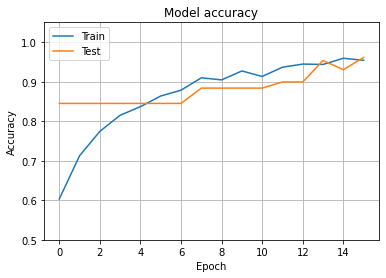

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

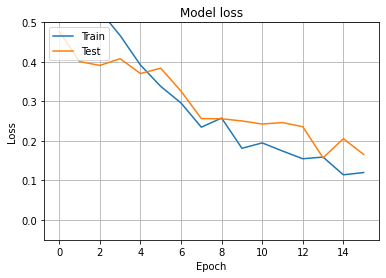

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("yamaoka.h5")